<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

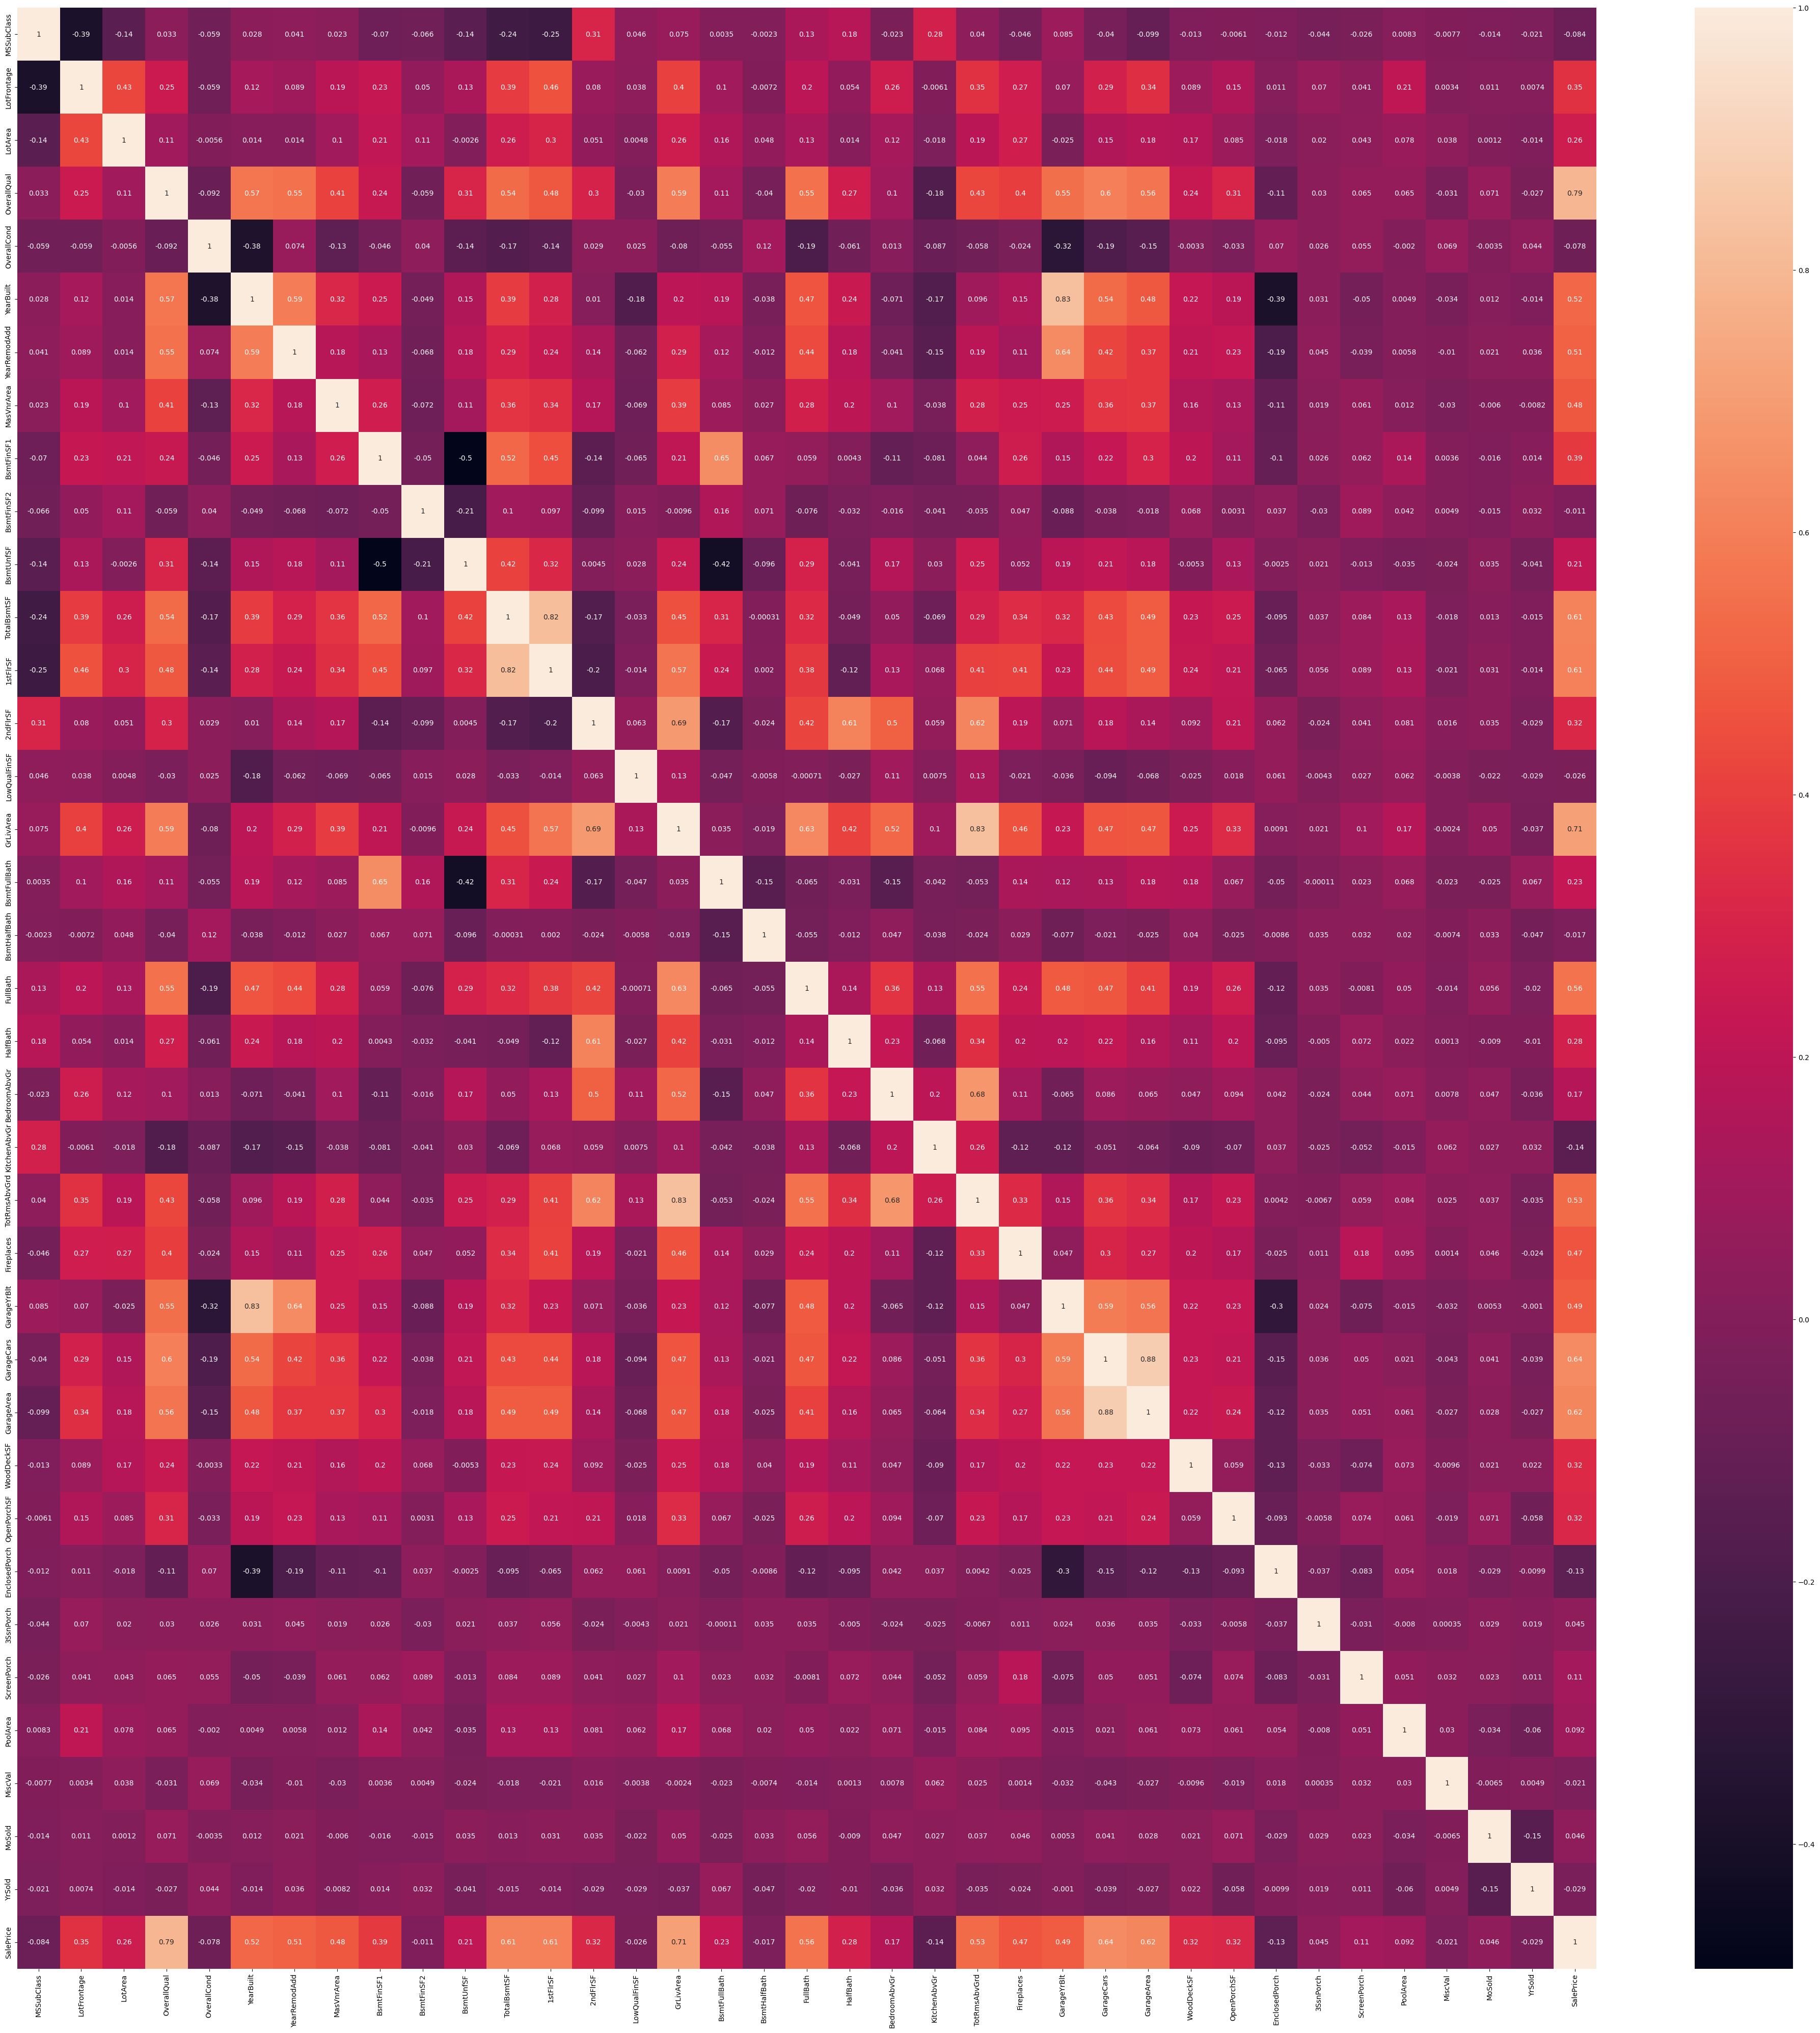

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import scipy
from scipy import stats

from statsmodels.stats.stattools import durbin_watson
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

housing= pd.read_csv("./train.csv")

housing = housing.drop(housing.columns[housing.isna().all()].tolist(),axis=1)
housing = housing.drop(['Id'],axis=1)# Dropping the Id column

print(housing.info())
print(housing.describe())

# Select only the numerical columns
numerical_cols = housing.select_dtypes(include=['float64', 'int64']).columns.tolist()
housing_num = housing[numerical_cols]

# Print the summary statistics of the numerical variables
print(housing_num.describe())

# Plot the correlation matrix
plt.figure(figsize=(50, 50))
sns.heatmap(housing_num.corr(), annot=True)
plt.show()

In [2]:
def printDescription(df,_list):
    print(df[_list].describe())
    
def identifyNullValueRows(df,_list):
    for i in _list:
        if(housing[i].isna().values.any()):
            print(str(i))
            print(housing[housing[i].isna()].count())
            print("\n")            
            
def boxsubplot(axes,df,xaxisParameter,yaxisParameter):
    if(yaxisParameter):
        sns.boxplot(ax=axes,data=df, x=xaxisParameter, y=yaxisParameter)
    else:
        sns.boxplot(ax=axes,data=df, x=xaxisParameter)
    axes.tick_params(axis='x', rotation=90)
    axes.set_title(xaxisParameter)
    axes.tick_params(axis='both', which='both', labelsize=7, labelbottom=True)

# Understanding and cleaning data

In [3]:
housing_data = housing[housing.columns]

printDescription(housing_data,['LotFrontage','LotArea'])
printDescription(housing_data,['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope'])

identifyNullValueRows(housing_data,['MSSubClass','LotFrontage','LotArea','MSZoning','Street','Alley',
                   'LotShape','LandContour','Utilities','LotConfig','LandSlope'])

housing_data.LotFrontage=housing_data.LotFrontage.fillna(0)

print("-----------------------------------------------------------------------------")
printDescription(housing_data,['OverallCond','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle'])
printDescription(housing_data,['OverallQual','YearBuilt','YearRemodAdd'])

identifyNullValueRows(housing_data,['Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                          'OverallQual','OverallCond','YearBuilt','YearRemodAdd'])

print("-----------------------------------------------------------------------------")

printDescription(housing_data,['RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond'])
printDescription(housing_data,['MasVnrArea'])

identifyNullValueRows(housing_data,['RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',
                           'Foundation','BsmtQual','BsmtCond','MasVnrArea'])

housing_data.MasVnrType=housing_data.MasVnrType.fillna('None')

# BsmtQual TA when OverallQual 3,4,5,6
# BsmtQual Gd when OverallQual 7
housing_data.loc[(housing_data.BsmtQual.isna()) & (housing_data.OverallQual==7),'BsmtQual']='Gd'
housing_data.loc[(housing_data.BsmtQual.isna()),'BsmtQual']='TA'

#TA
#housing.loc[(housing.OverallCond.isin([3,4,5,6,7]))]['BsmtCond'].value_counts()
housing_data.loc[(housing_data.BsmtCond.isna()),'BsmtCond']='TA'

housing_data.loc[(housing_data.MasVnrArea.isna() & (housing_data.MasVnrType=='BrkCmn')),'MasVnrArea'] = housing_data.loc[~((housing_data.MasVnrArea.isna()) & (housing_data.MasVnrType=='BrkCmn')),'MasVnrArea'].mean()
housing_data.loc[(housing_data.MasVnrArea.isna() & (housing_data.MasVnrType=='BrkFace')),'MasVnrArea'] = housing_data.loc[~((housing_data.MasVnrArea.isna()) & (housing_data.MasVnrType=='BrkFace')),'MasVnrArea'].mean()
housing_data.loc[(housing_data.MasVnrArea.isna() & (housing_data.MasVnrType=='CBlock')),'MasVnrArea'] = housing_data.loc[~((housing_data.MasVnrArea.isna()) & (housing_data.MasVnrType=='CBlock')),'MasVnrArea'].mean()
housing_data.loc[(housing_data.MasVnrArea.isna() & (housing_data.MasVnrType=='None')),'MasVnrArea'] = housing_data.loc[~((housing_data.MasVnrArea.isna()) & (housing_data.MasVnrType=='None')),'MasVnrArea'].mean()
housing_data.loc[(housing_data.MasVnrArea.isna() & (housing_data.MasVnrType=='Stone')),'MasVnrArea'] = housing_data.loc[~((housing_data.MasVnrArea.isna()) & (housing_data.MasVnrType=='Stone')),'MasVnrArea'].mean()

print("-----------------------------------------------------------------------------")

printDescription(housing_data,['BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir'])
printDescription(housing_data,['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'])

identifyNullValueRows(housing_data,['BsmtExposure','BsmtFinType1','BsmtFinType2','Heating',
                           'HeatingQC','CentralAir','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'])


housing_data.BsmtExposure=housing_data.BsmtExposure.fillna('NA')

housing_data.BsmtFinType1=housing_data.BsmtFinType1.fillna('NA')
housing_data.BsmtFinType2=housing_data.BsmtFinType2.fillna('NA')

print("-----------------------------------------------------------------------------")

printDescription(housing_data,['1stFlrSF','2ndFlrSF','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr'])

printDescription(housing_data,['Electrical','GrLivArea'])

identifyNullValueRows(housing_data,['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','Electrical'])

housing_data.Electrical=housing_data.Electrical.fillna('SBrkr')

print("-----------------------------------------------------------------------------")

printDescription(housing_data,['Functional','KitchenQual','FireplaceQu','GarageType','GarageFinish'])
printDescription(housing_data,['KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars'])

identifyNullValueRows(housing_data,['Functional','KitchenQual','FireplaceQu','GarageType','GarageFinish','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars'])

housing_data.GarageYrBlt=housing_data.GarageYrBlt.fillna(0)
housing_data.GarageType=housing_data.GarageType.fillna('NA')
housing_data.GarageFinish=housing_data.GarageFinish.fillna('NA')

print("-----------------------------------------------------------------------------")

printDescription(housing_data,['GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea'])

printDescription(housing_data,['GarageQual','GarageCond','PavedDrive'])

identifyNullValueRows(housing_data,['GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','GarageQual','GarageCond','PavedDrive'])

housing_data.GarageQual=housing_data.GarageQual.fillna('NA')
housing_data.GarageCond=housing_data.GarageCond.fillna('NA')

printDescription(housing_data,['PoolQC','Fence','MiscFeature','SaleType','SaleCondition'])
printDescription(housing_data,['MiscVal','MoSold','YrSold','SalePrice'])

identifyNullValueRows(housing_data,['PoolQC','Fence','MiscFeature','SaleType','SaleCondition','MiscVal','MoSold','YrSold','SalePrice'])

print("-----------------------------------------------------------------------------")

housing_data.Fence=housing_data.Fence.fillna('NA')
housing_data.MiscFeature=housing_data.MiscFeature.fillna('NA')
housing_data.FireplaceQu=housing_data.FireplaceQu.fillna('NA')

housing_data = housing_data.drop(['Alley','PoolQC'],axis=1)# Dropping Alley as it has many Nan and is insignificant w.r.t to the target parameter even after splitting based on values


       LotFrontage        LotArea
count  1201.000000    1460.000000
mean     70.049958   10516.828082
std      24.284752    9981.264932
min      21.000000    1300.000000
25%      59.000000    7553.500000
50%      69.000000    9478.500000
75%      80.000000   11601.500000
max     313.000000  215245.000000
        MSSubClass
count  1460.000000
mean     56.897260
std      42.300571
min      20.000000
25%      20.000000
50%      50.000000
75%      70.000000
max     190.000000
LotFrontage
MSSubClass       259
MSZoning         259
LotFrontage        0
LotArea          259
Street           259
                ... 
MoSold           259
YrSold           259
SaleType         259
SaleCondition    259
SalePrice        259
Length: 80, dtype: int64


Alley
MSSubClass       1369
MSZoning         1369
LotFrontage      1115
LotArea          1369
Street           1369
                 ... 
MoSold           1369
YrSold           1369
SaleType         1369
SaleCondition    1369
SalePrice        1369
Lengt

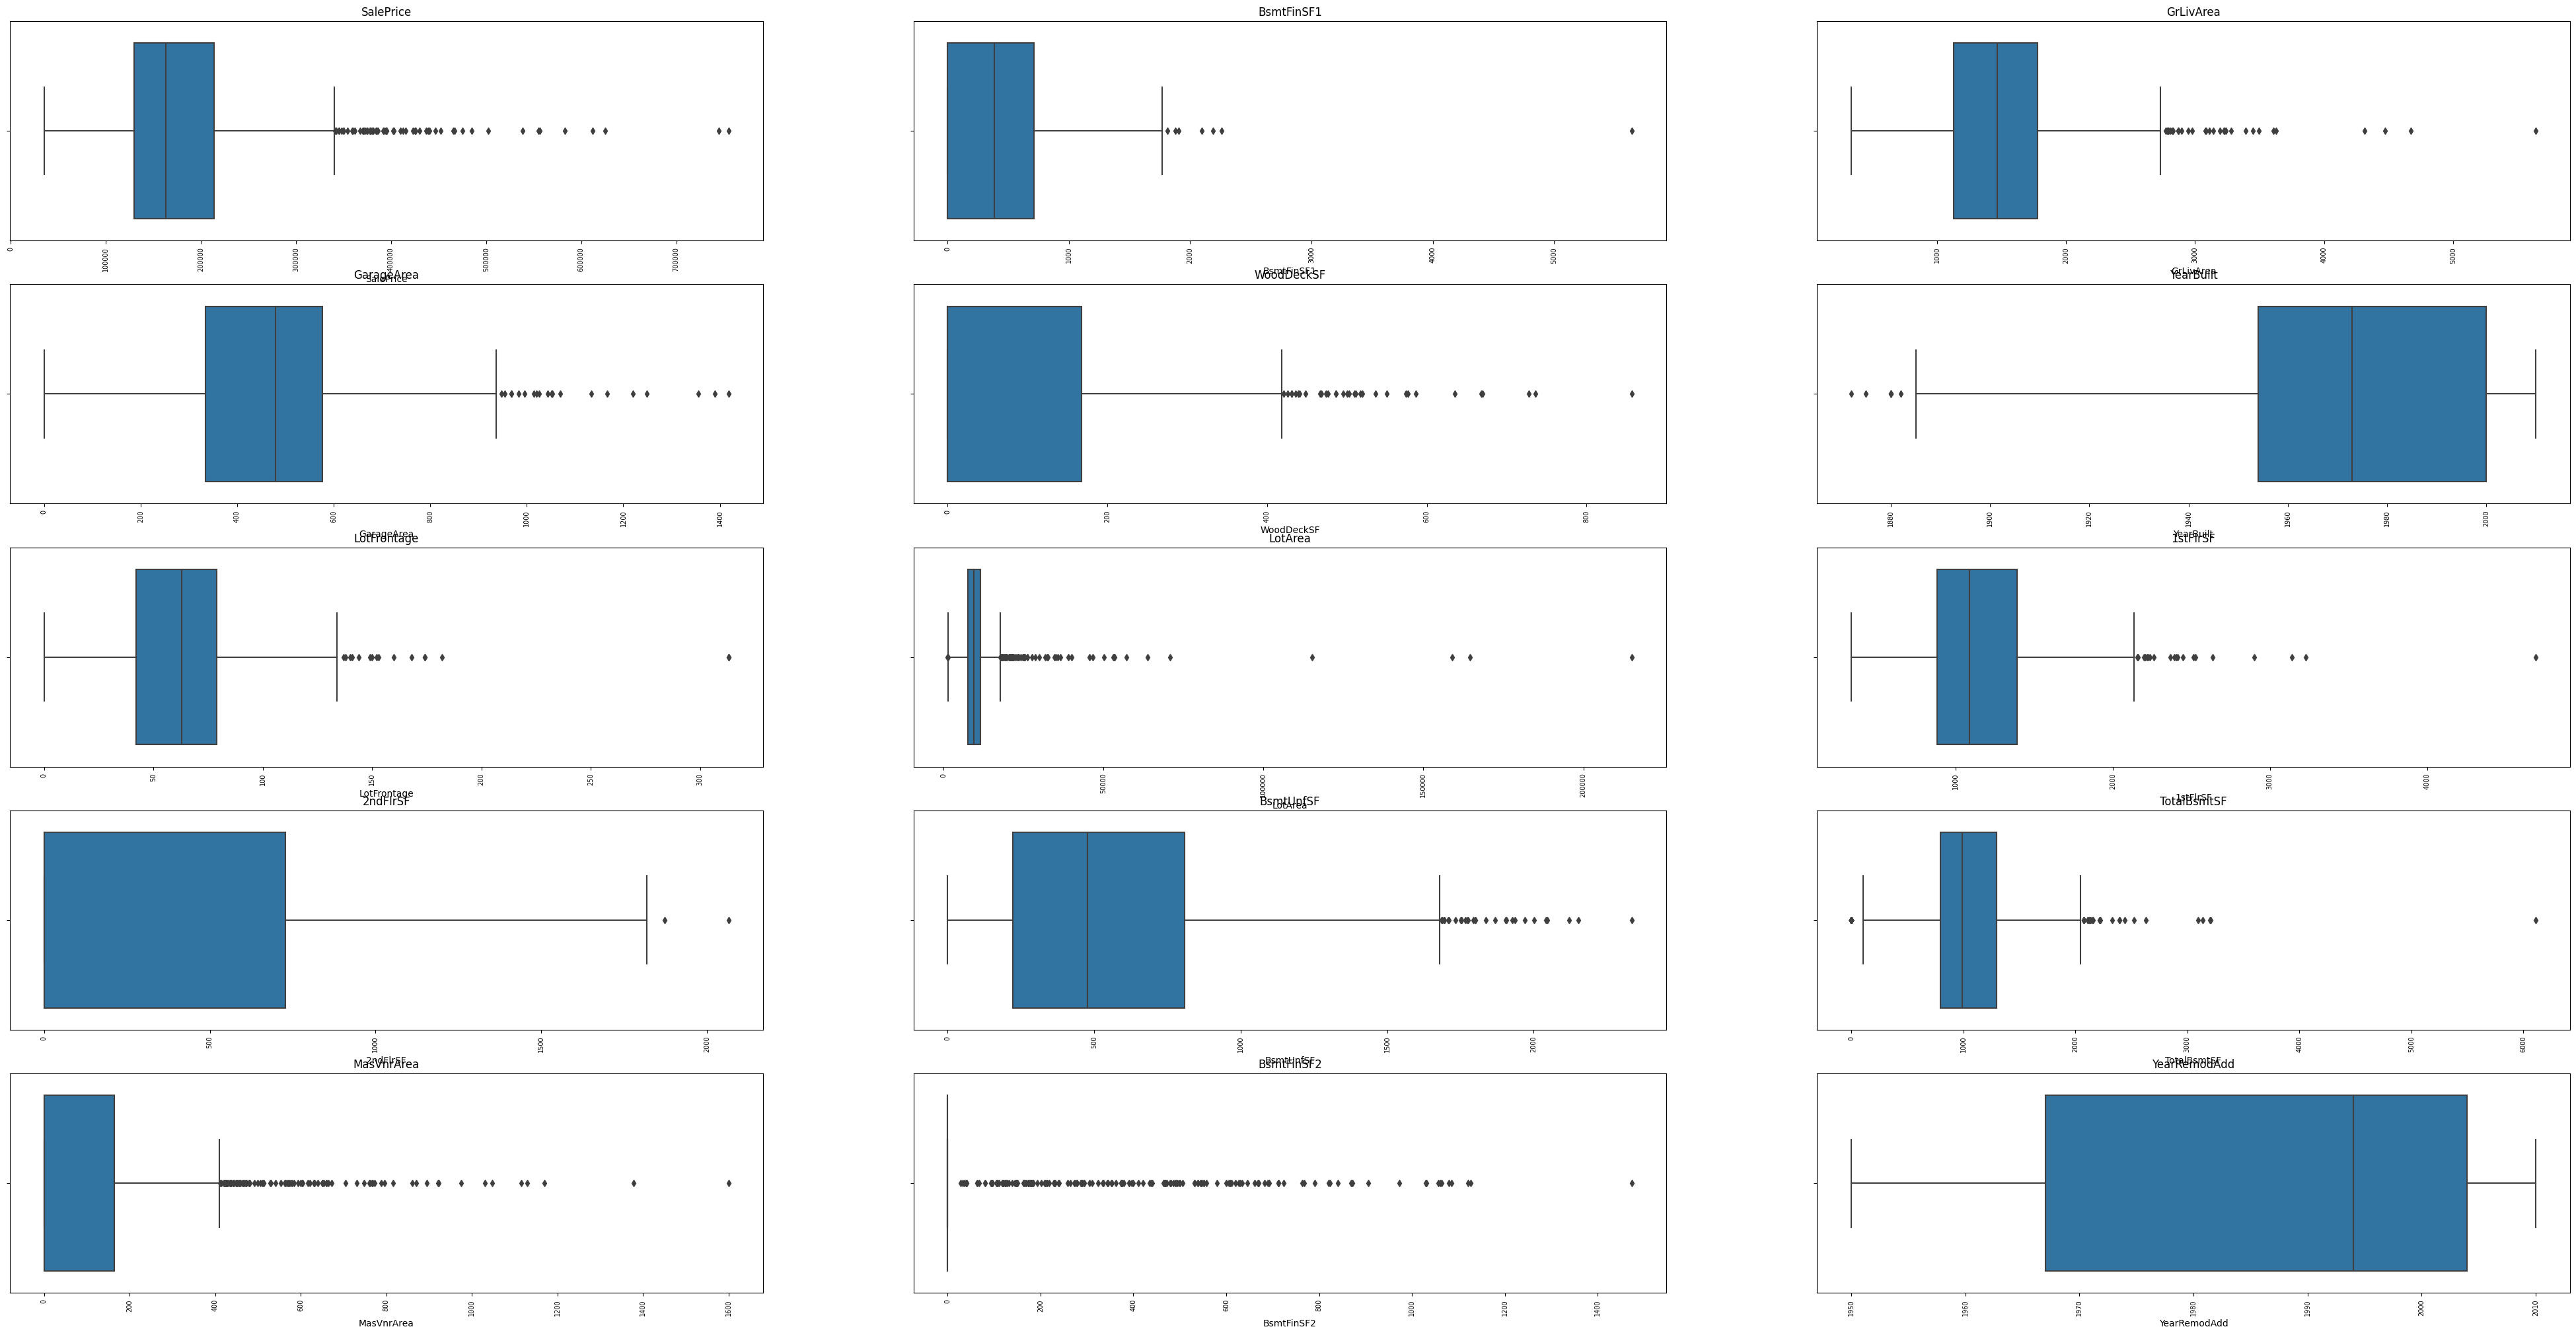

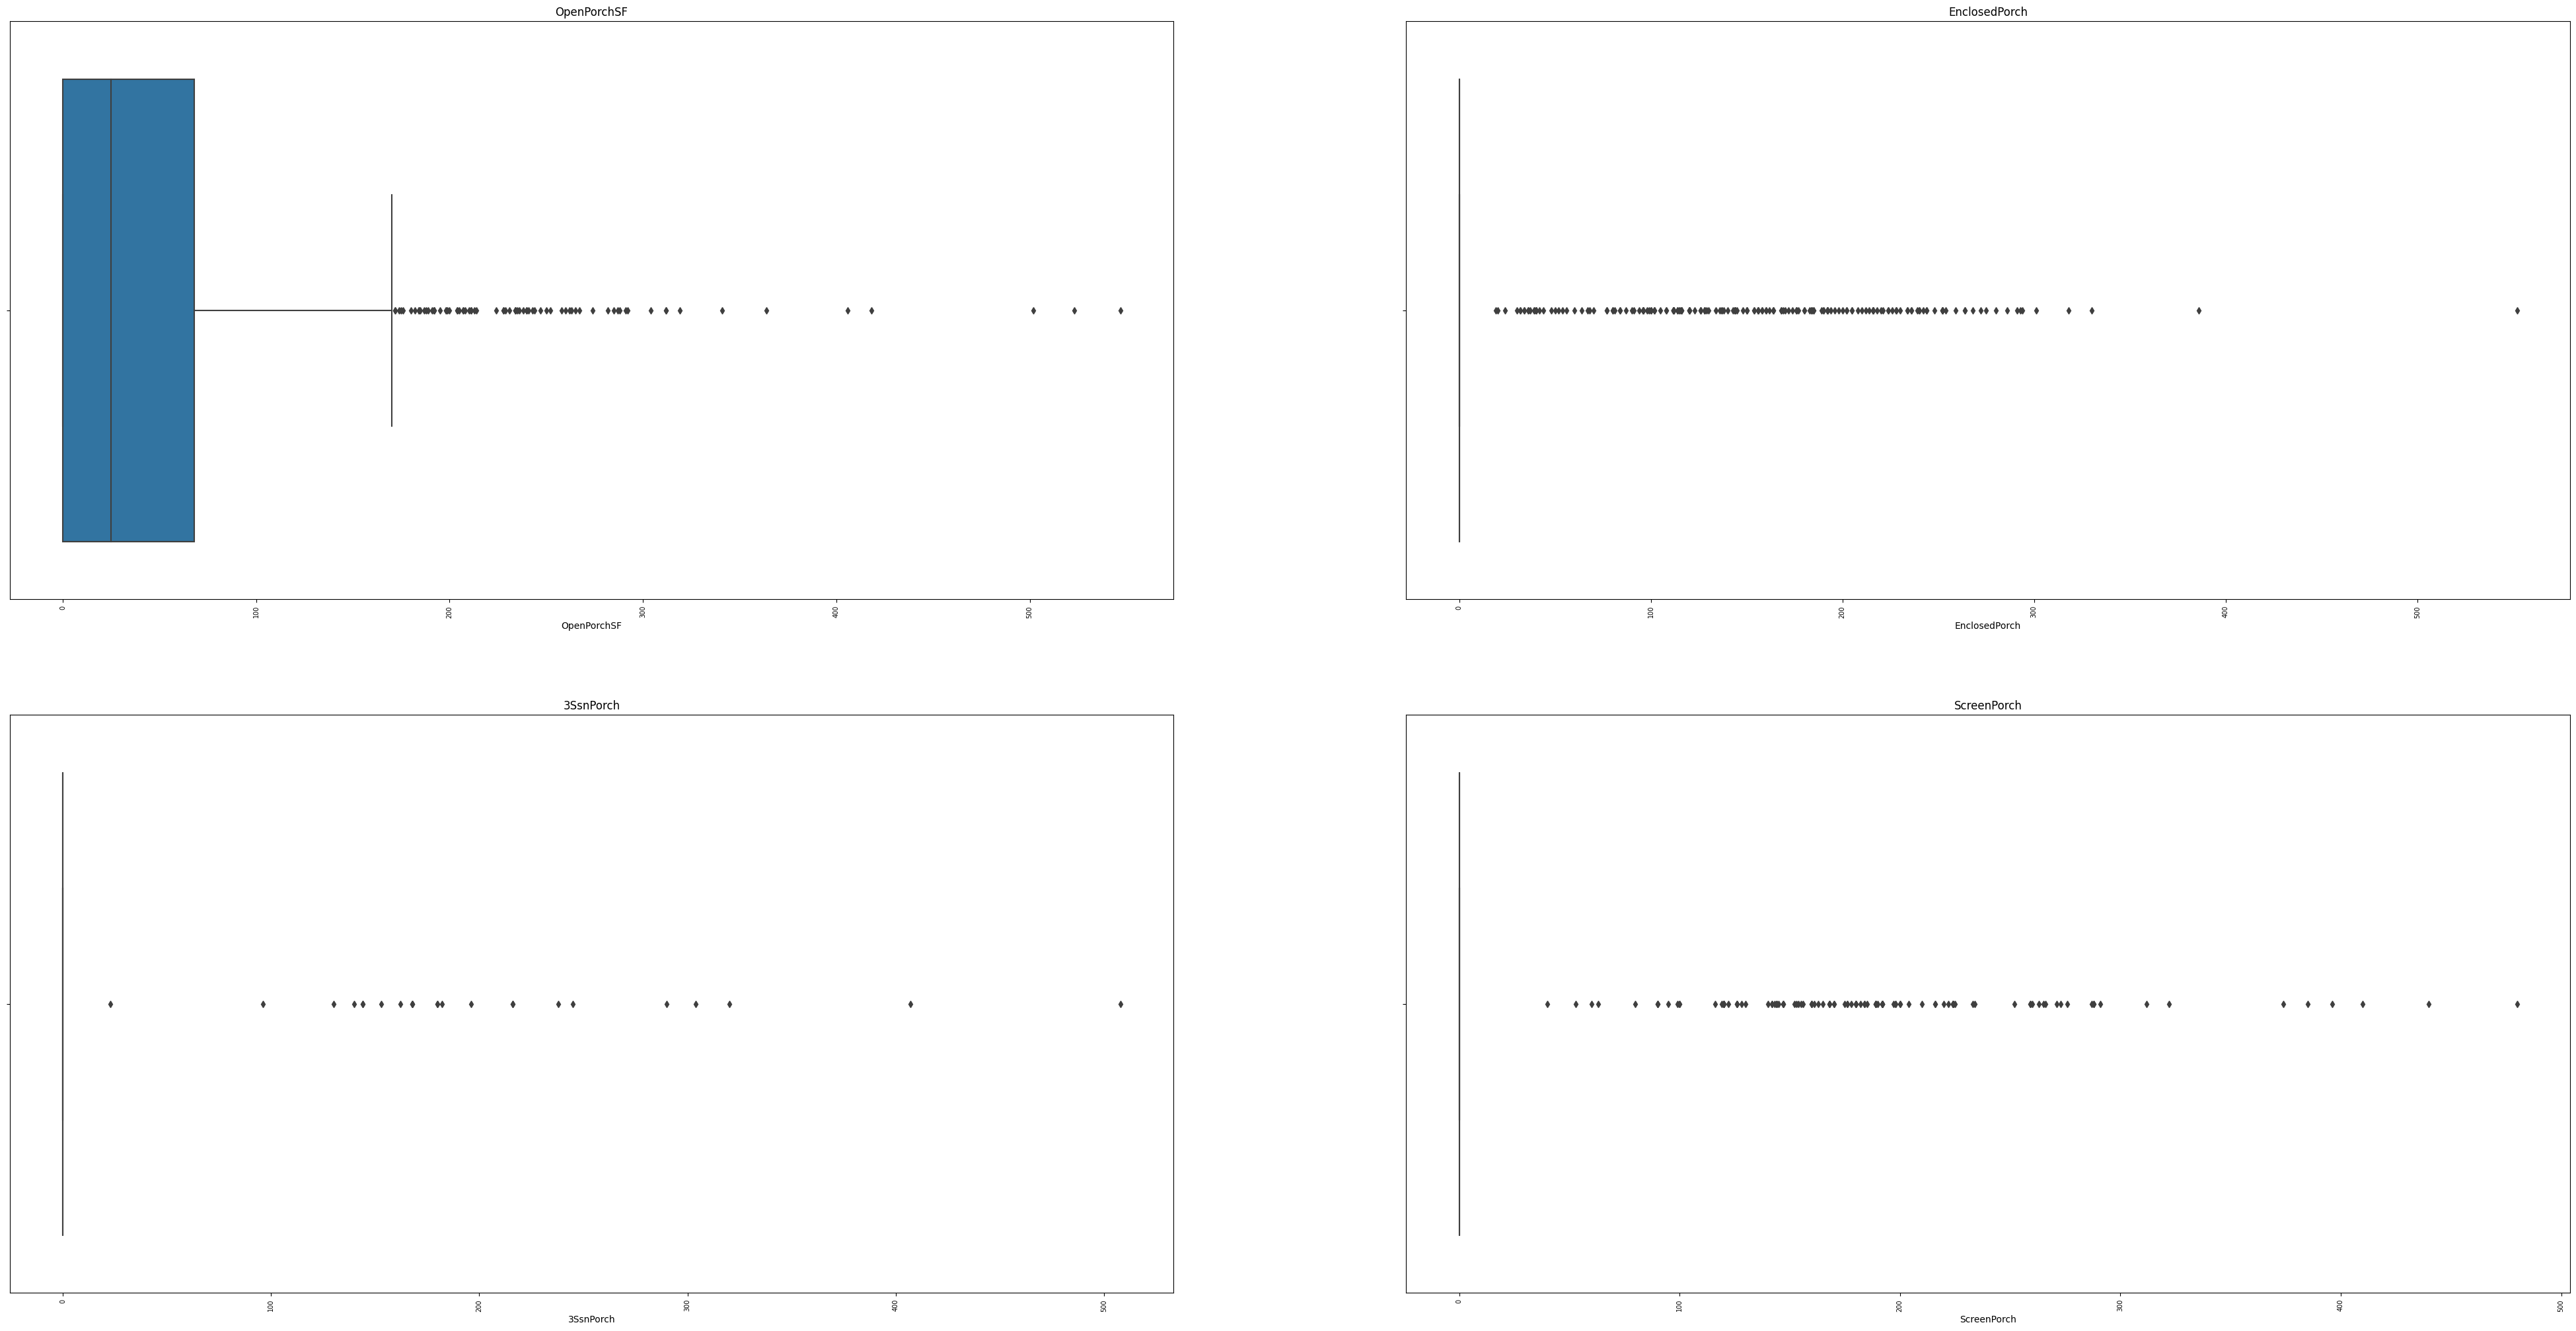

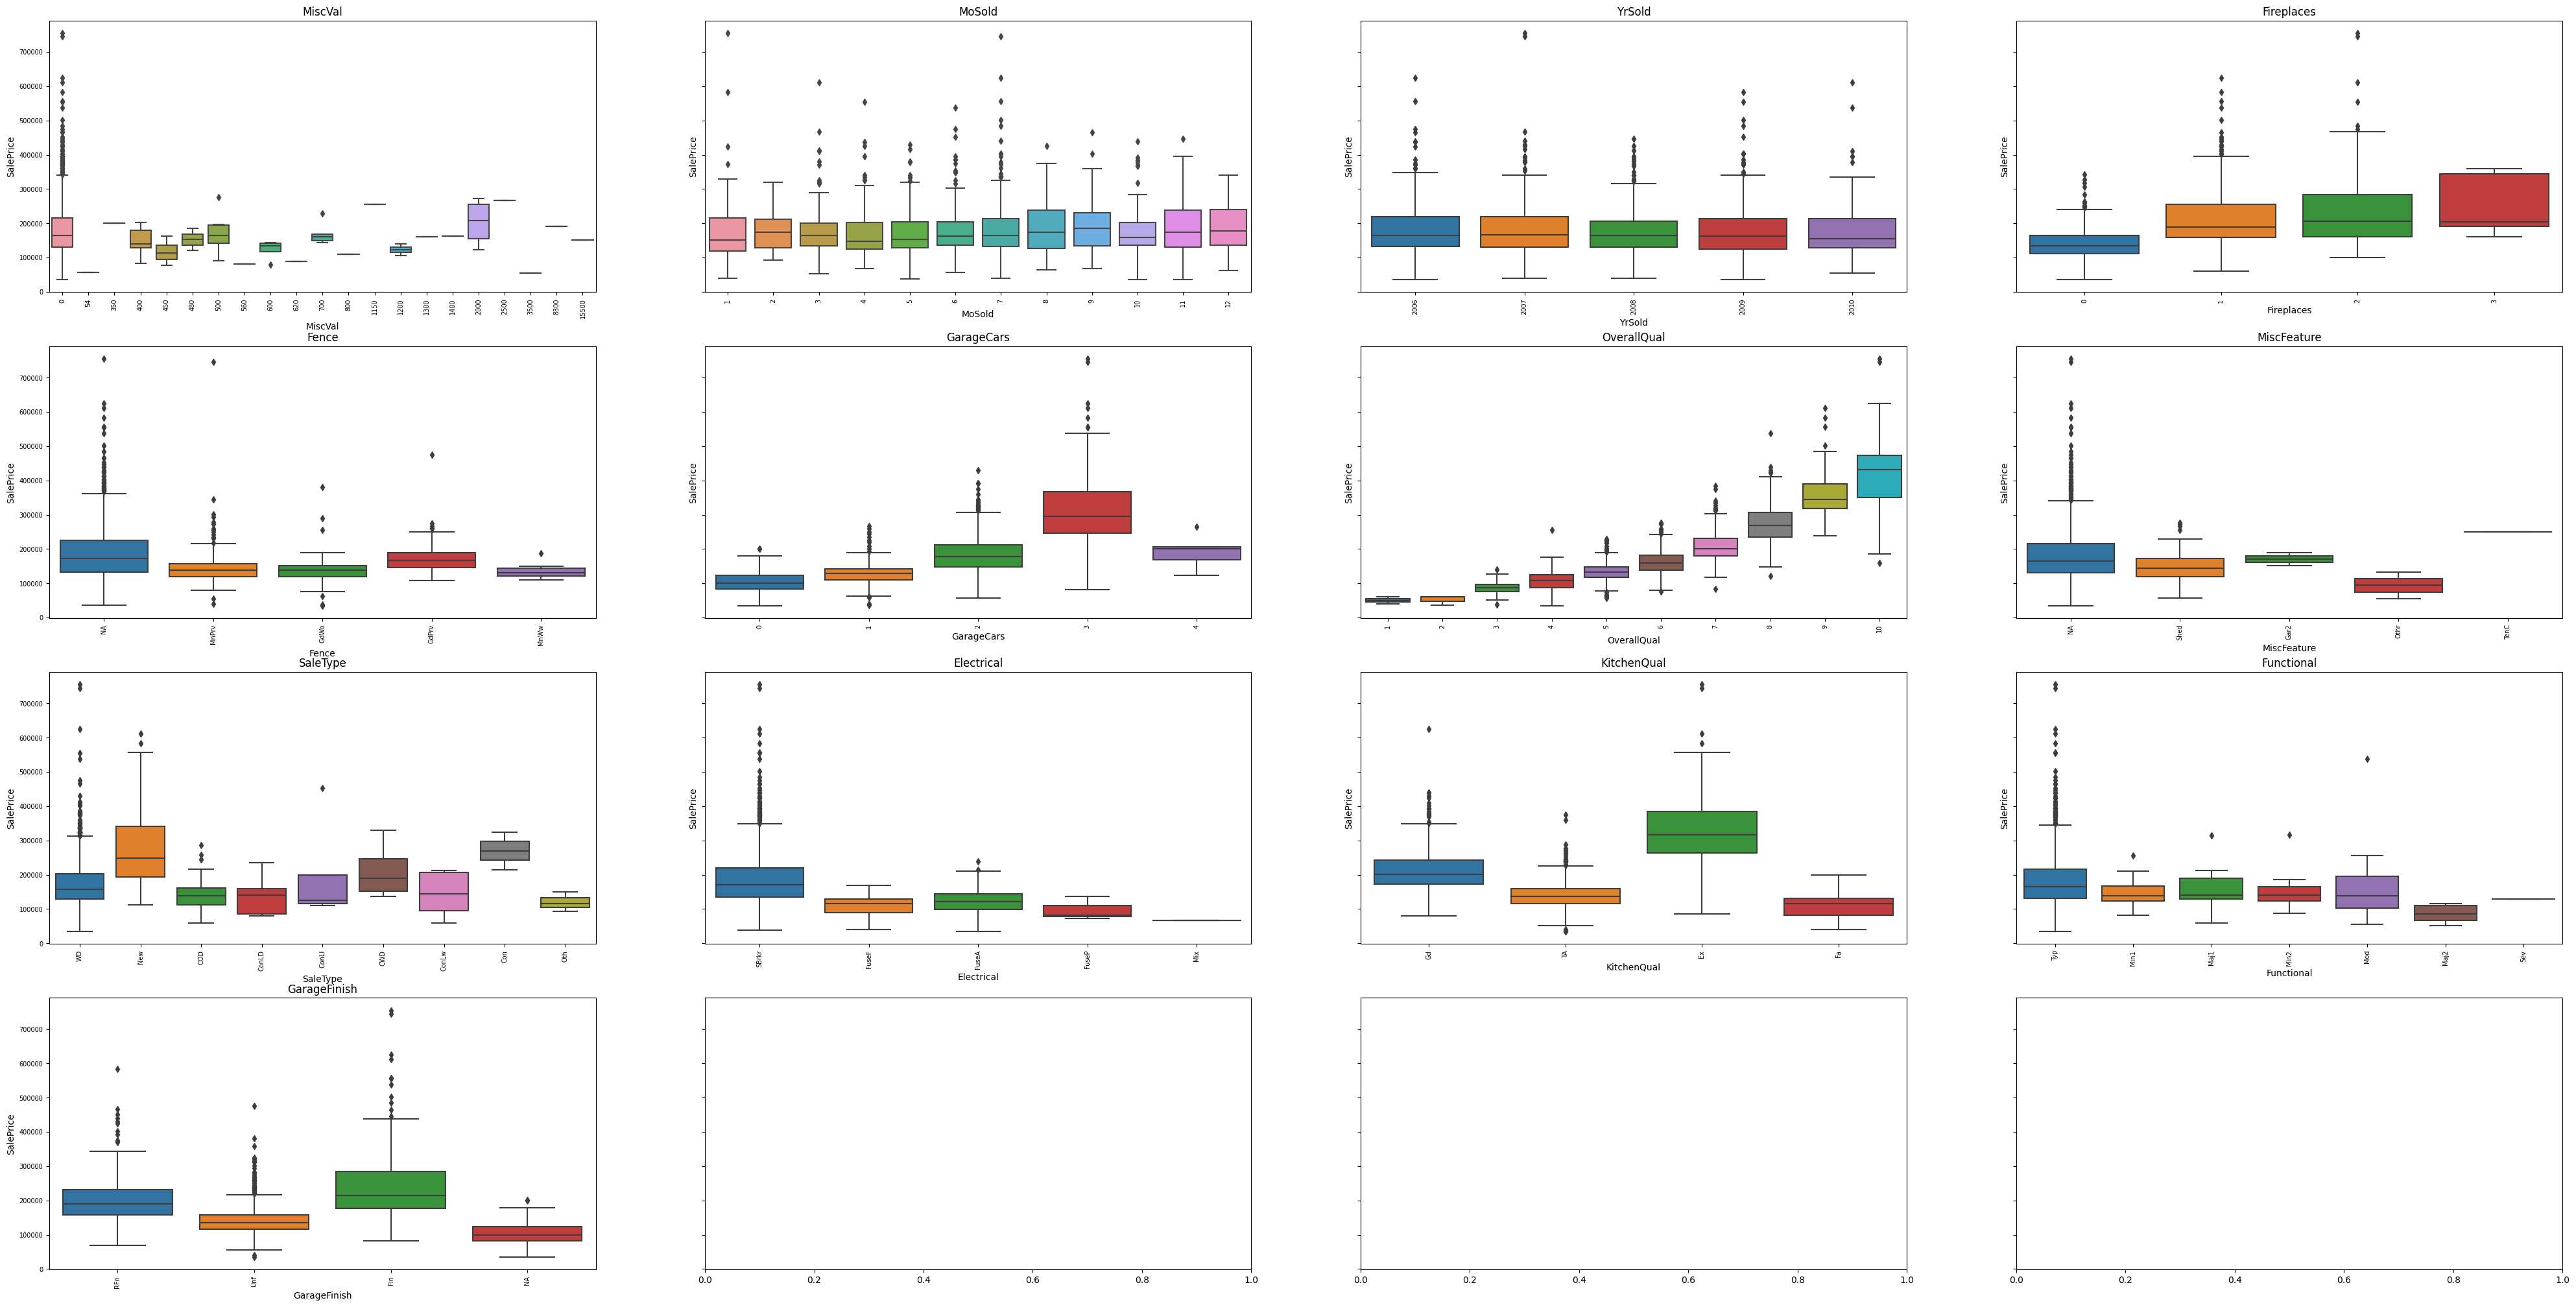

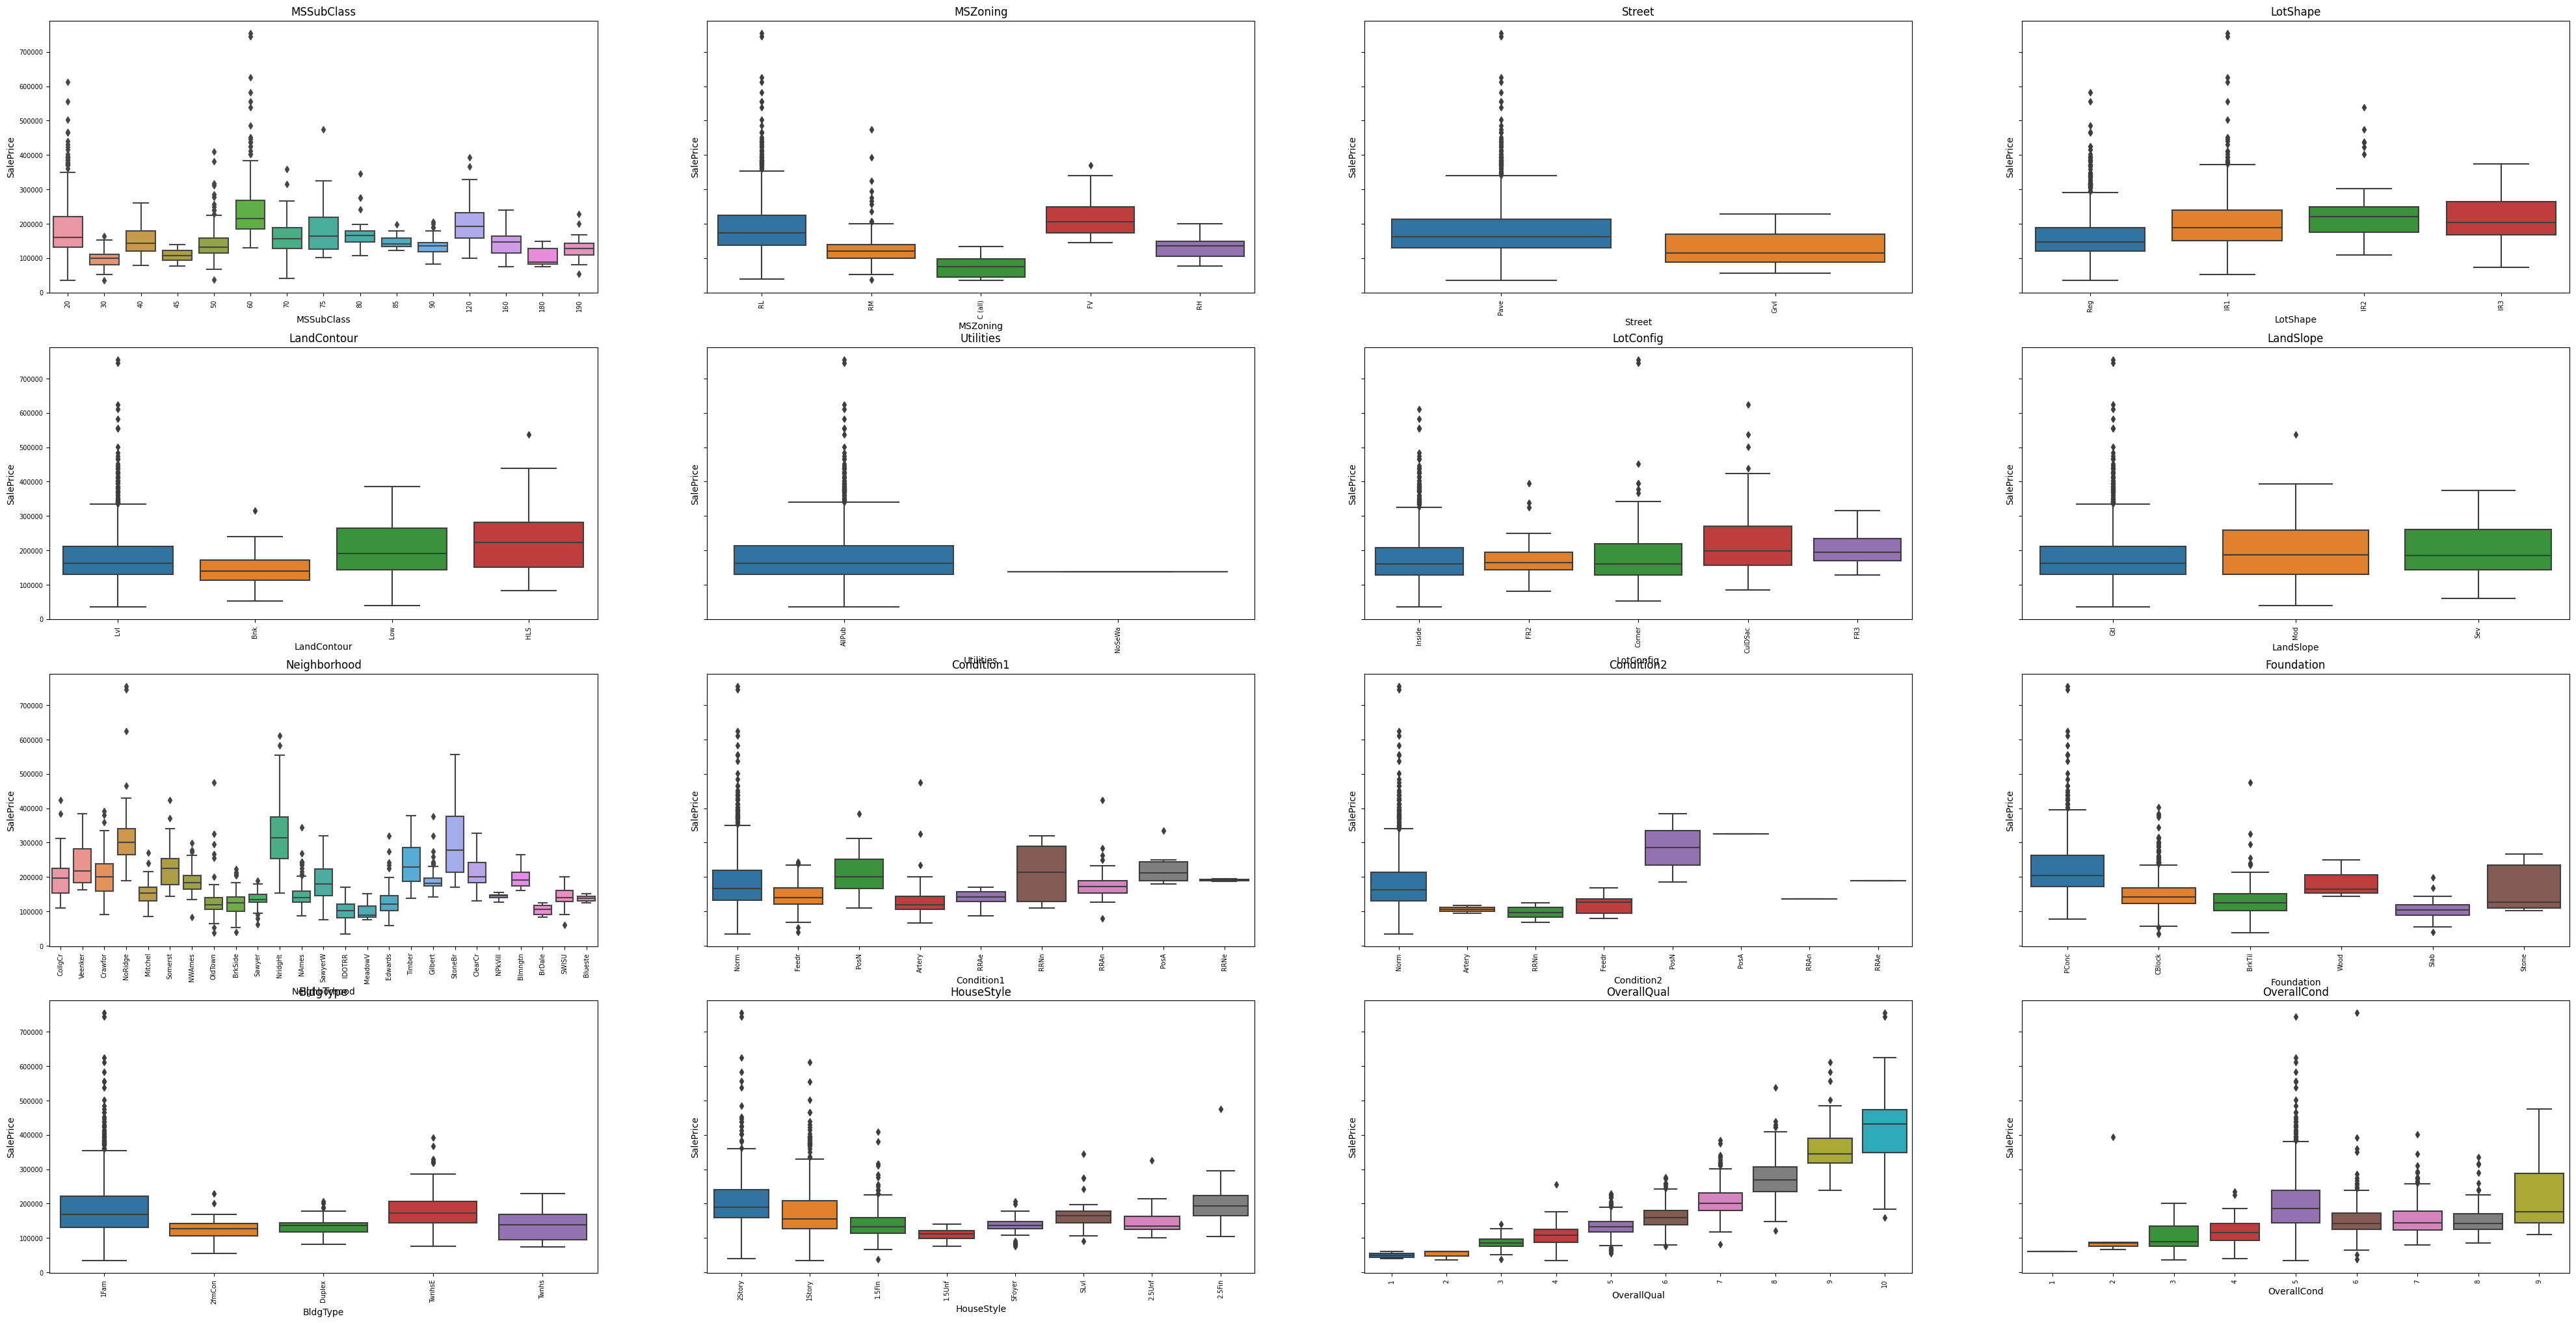

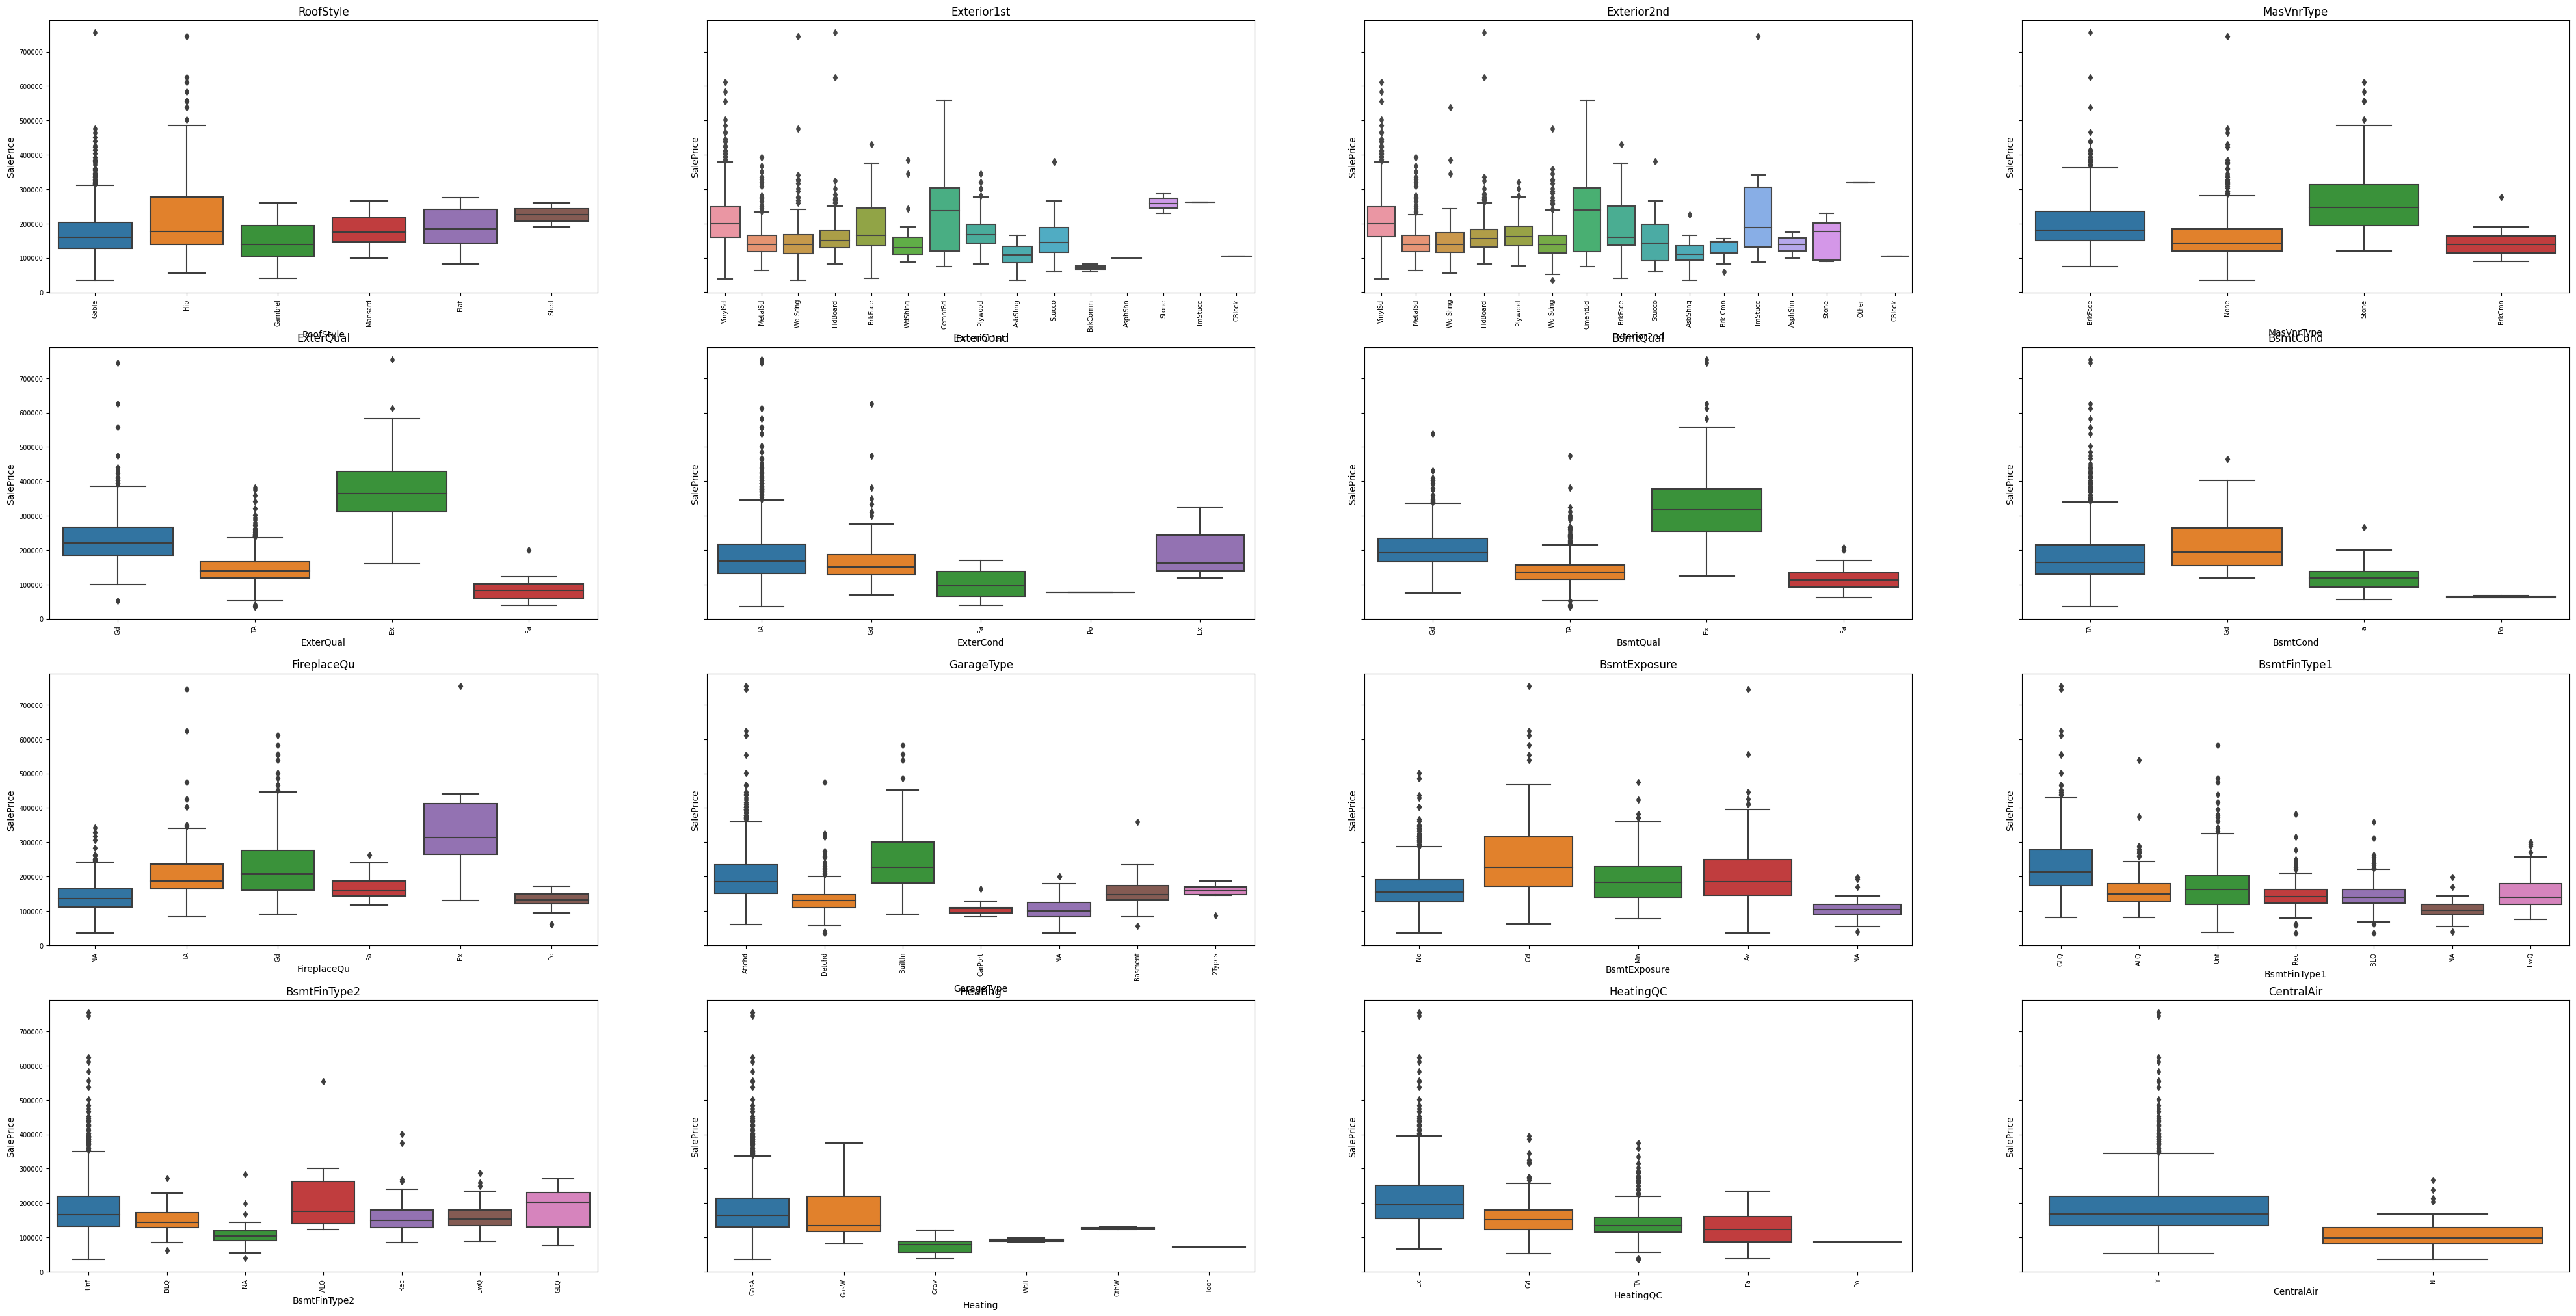

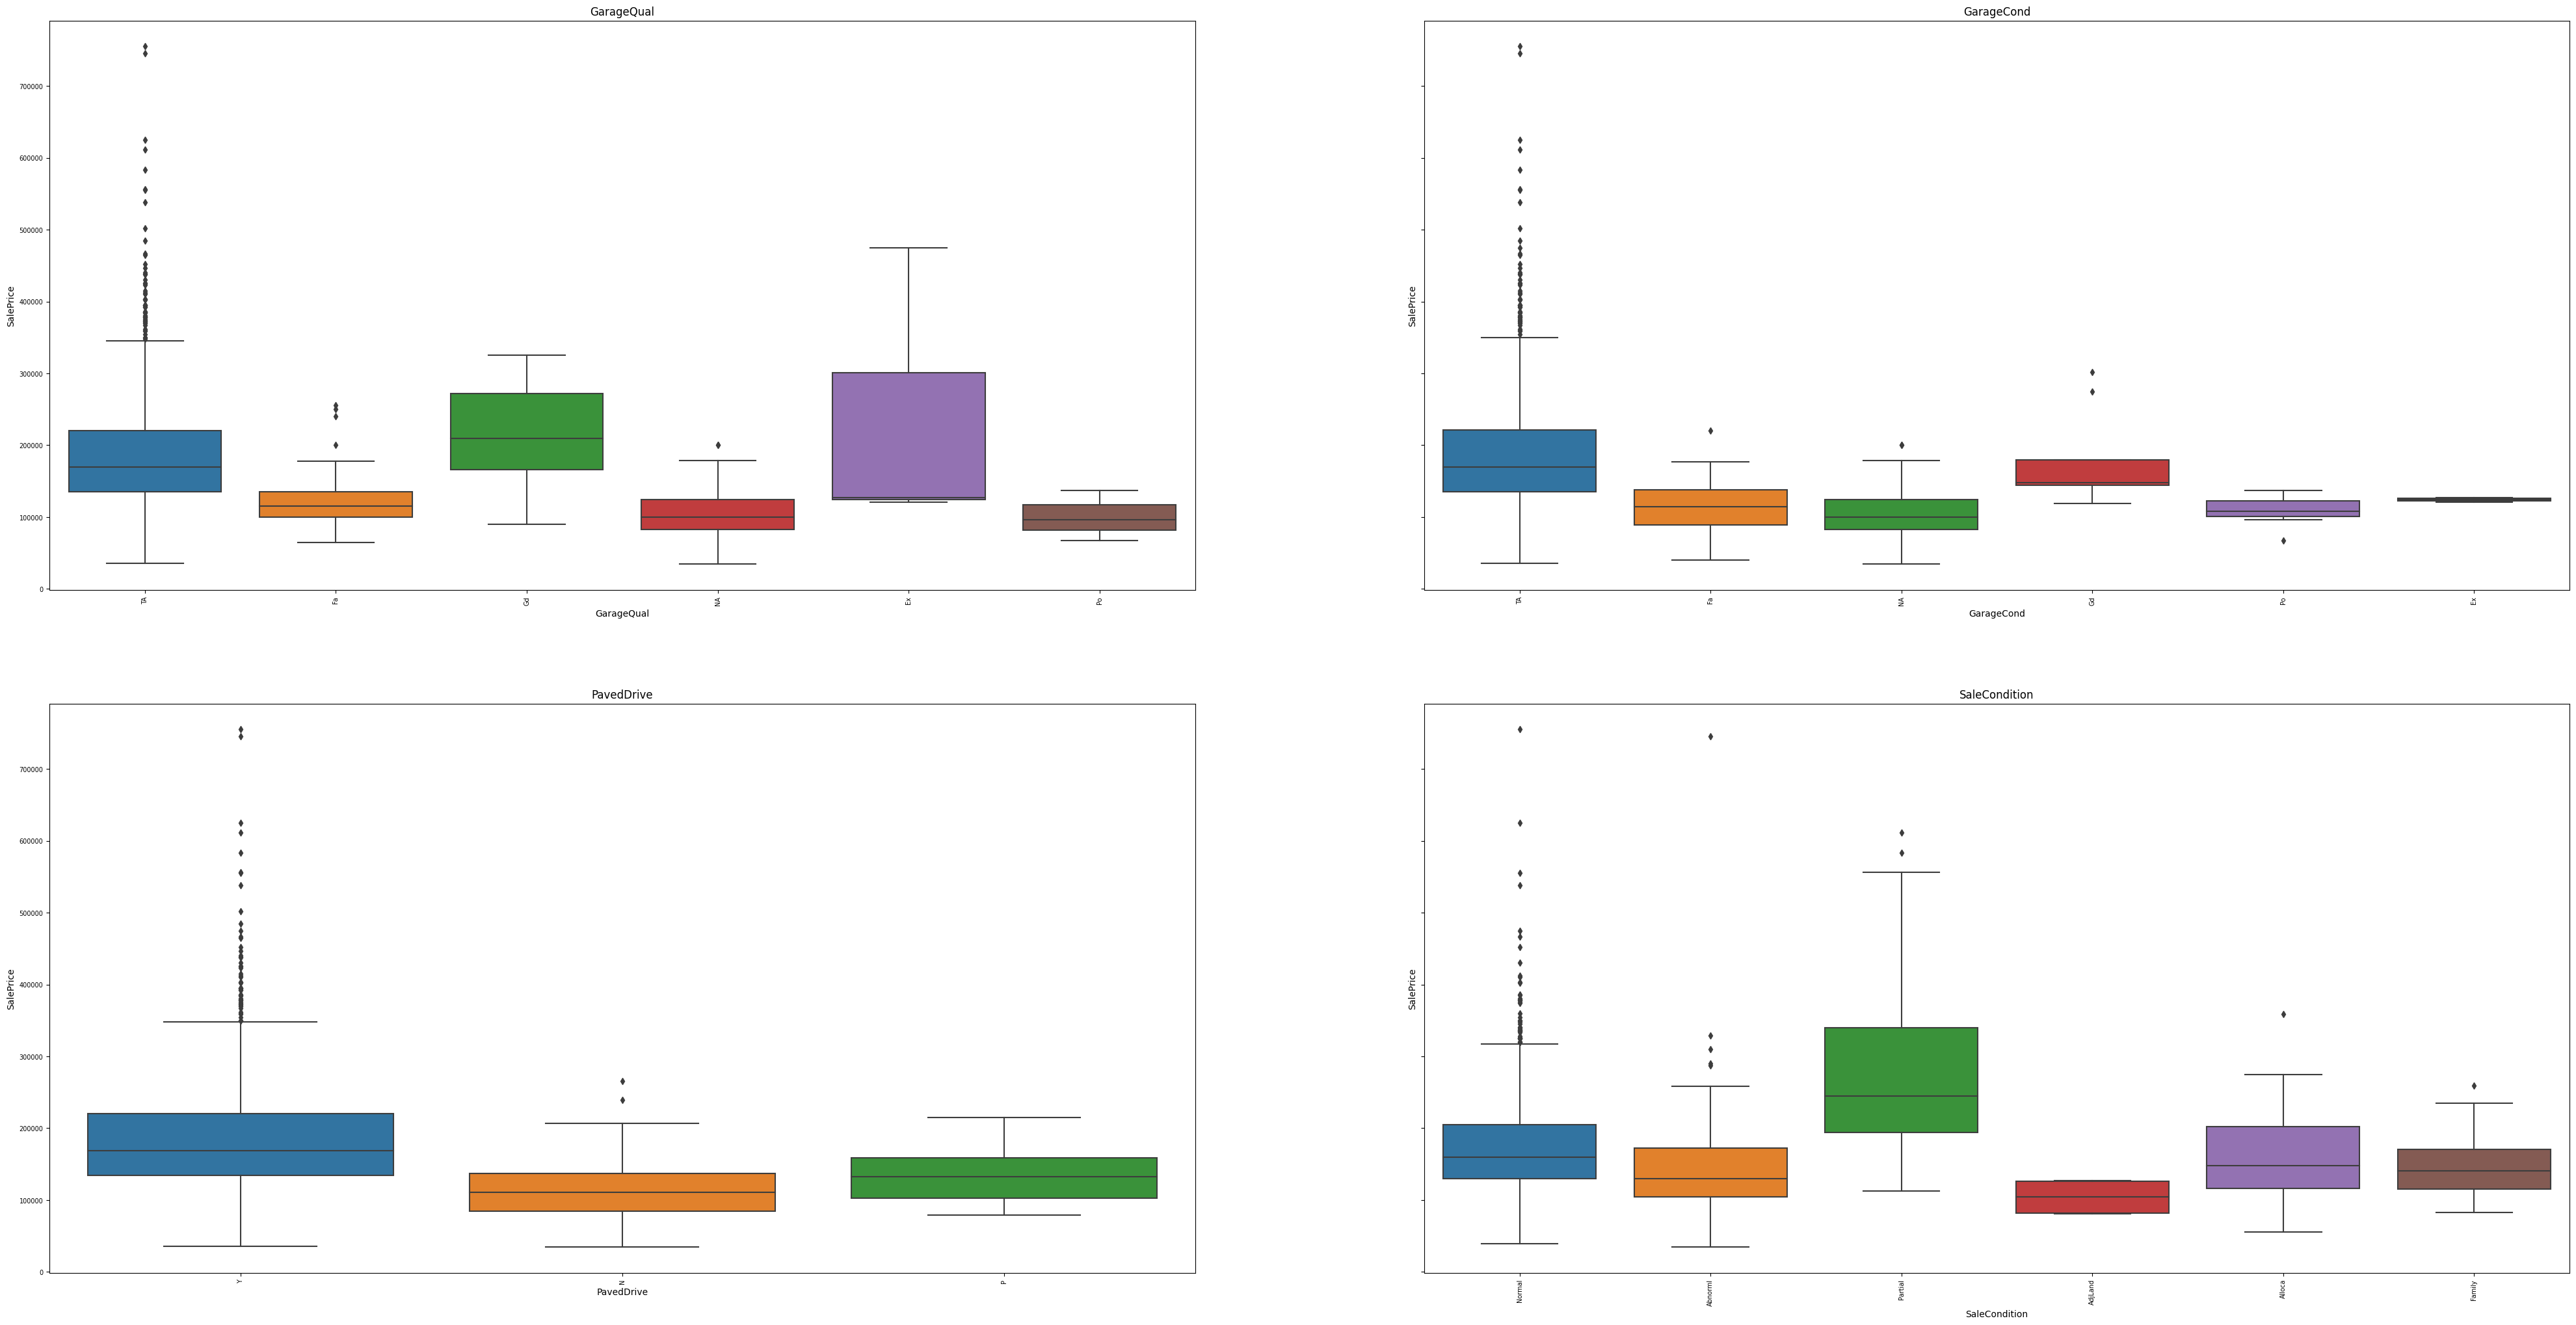

In [4]:
def plotSubplots(df,xCols,y,rowCount,colCount):
    fig, axes = plt.subplots(rowCount, colCount, figsize=(50, 25),sharey=True)

    colIndex=0
    for row in range(0,rowCount):
        if(len(xCols)==colIndex):
            break
        for i in range(0,colCount):
            if(len(xCols)==colIndex):
                break
            boxsubplot(axes[row,i],df, xCols[colIndex], y)
            colIndex=colIndex+1

            
plotSubplots(housing_data,['SalePrice','BsmtFinSF1','GrLivArea',
              'GarageArea', 'WoodDeckSF',
              'YearBuilt','LotFrontage','LotArea',
              '1stFlrSF','2ndFlrSF','BsmtUnfSF','TotalBsmtSF',
              'MasVnrArea','BsmtFinSF2','YearRemodAdd'],None,5,3)

plotSubplots(housing_data,['OpenPorchSF','EnclosedPorch','3SsnPorch',
              'ScreenPorch'],None,2,2)
plotSubplots(housing_data,['MiscVal','MoSold','YrSold',
             'Fireplaces','Fence','GarageCars','OverallQual',
              'MiscFeature','SaleType','Electrical', 
              'KitchenQual','Functional','GarageFinish'],'SalePrice',4,4)

plotSubplots(housing_data,['MSSubClass','MSZoning','Street','LotShape',
              'LandContour','Utilities','LotConfig','LandSlope',
              'Neighborhood', 'Condition1','Condition2','Foundation',
             'BldgType','HouseStyle','OverallQual','OverallCond'],'SalePrice',4,4)

plotSubplots(housing_data,['RoofStyle','Exterior1st','Exterior2nd','MasVnrType',
              'ExterQual', 'ExterCond','BsmtQual','BsmtCond',
             'FireplaceQu','GarageType','BsmtExposure','BsmtFinType1',
              'BsmtFinType2','Heating','HeatingQC','CentralAir'],'SalePrice',4,4)

plotSubplots(housing_data,['GarageQual','GarageCond',
              'PavedDrive','SaleCondition'],'SalePrice',2,2)


# Type conversions

In [5]:
dict_map_MSSubClass = {20:'1-STORY 1946 & NEWER ALL STYLES', 
                                           30:'1-STORY 1945 & OLDER', 
                                           40:'1-STORY W/FINISHED ATTIC ALL AGES',
                                          45:'1-1/2 STORY - UNFINISHED ALL AGES',
                                          50:'1-1/2 STORY FINISHED ALL AGES',
                                          60:'2-STORY 1946 & NEWER',
                                          70:'2-STORY 1945 & OLDER',
                                          75:'2-1/2 STORY ALL AGES',
                                          80:'SPLIT OR MULTI-LEVEL',
                                          85:'SPLIT FOYER',
                                          90:'DUPLEX - ALL STYLES AND AGES',
                                          120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
                                          150:'1-1/2 STORY PUD - ALL AGES',
                                          160:'2-STORY PUD - 1946 & NEWER',
                                          180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                                          190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}

housing_data['MSSubClass'] = housing_data['MSSubClass'].map(dict_map_MSSubClass)

dict_map_OverallQual = {10:'Very Excellent',
                        9:'Excellent',
                        8:'Very Good',
                        7:'Good',
                        6:'Above Average',
                        5:'Average',
                        4:'Below Average',
                        3:'Fair',
                        2:'Poor',
                        1:'Very Poor'}

housing_data['OverallQual'] = housing_data['OverallQual'].map(dict_map_OverallQual)

dict_map_OverallCond = {10:'Very Excellent',
                        9:'Excellent',
                        8:'Very Good',
                        7:'Good',
                        6:'Above Average',
                        5:'Average',
                        4:'Below Average',
                        3:'Fair',
                        2:'Poor',
                        1:'Very Poor'}

housing_data['OverallCond'] = housing_data['OverallCond'].map(dict_map_OverallCond)

## Convert two columns to 'numeric' type as mentioned above
housing_data['LotFrontage'] = pd.to_numeric(housing_data['LotFrontage'])
housing_data['MasVnrArea'] = pd.to_numeric(housing_data['MasVnrArea'])

housing_data[['MSSubClass', 'OverallQual', 'OverallCond', 'LotFrontage', 'MasVnrArea']].dtypes

MSSubClass      object
OverallQual     object
OverallCond     object
LotFrontage    float64
MasVnrArea     float64
dtype: object

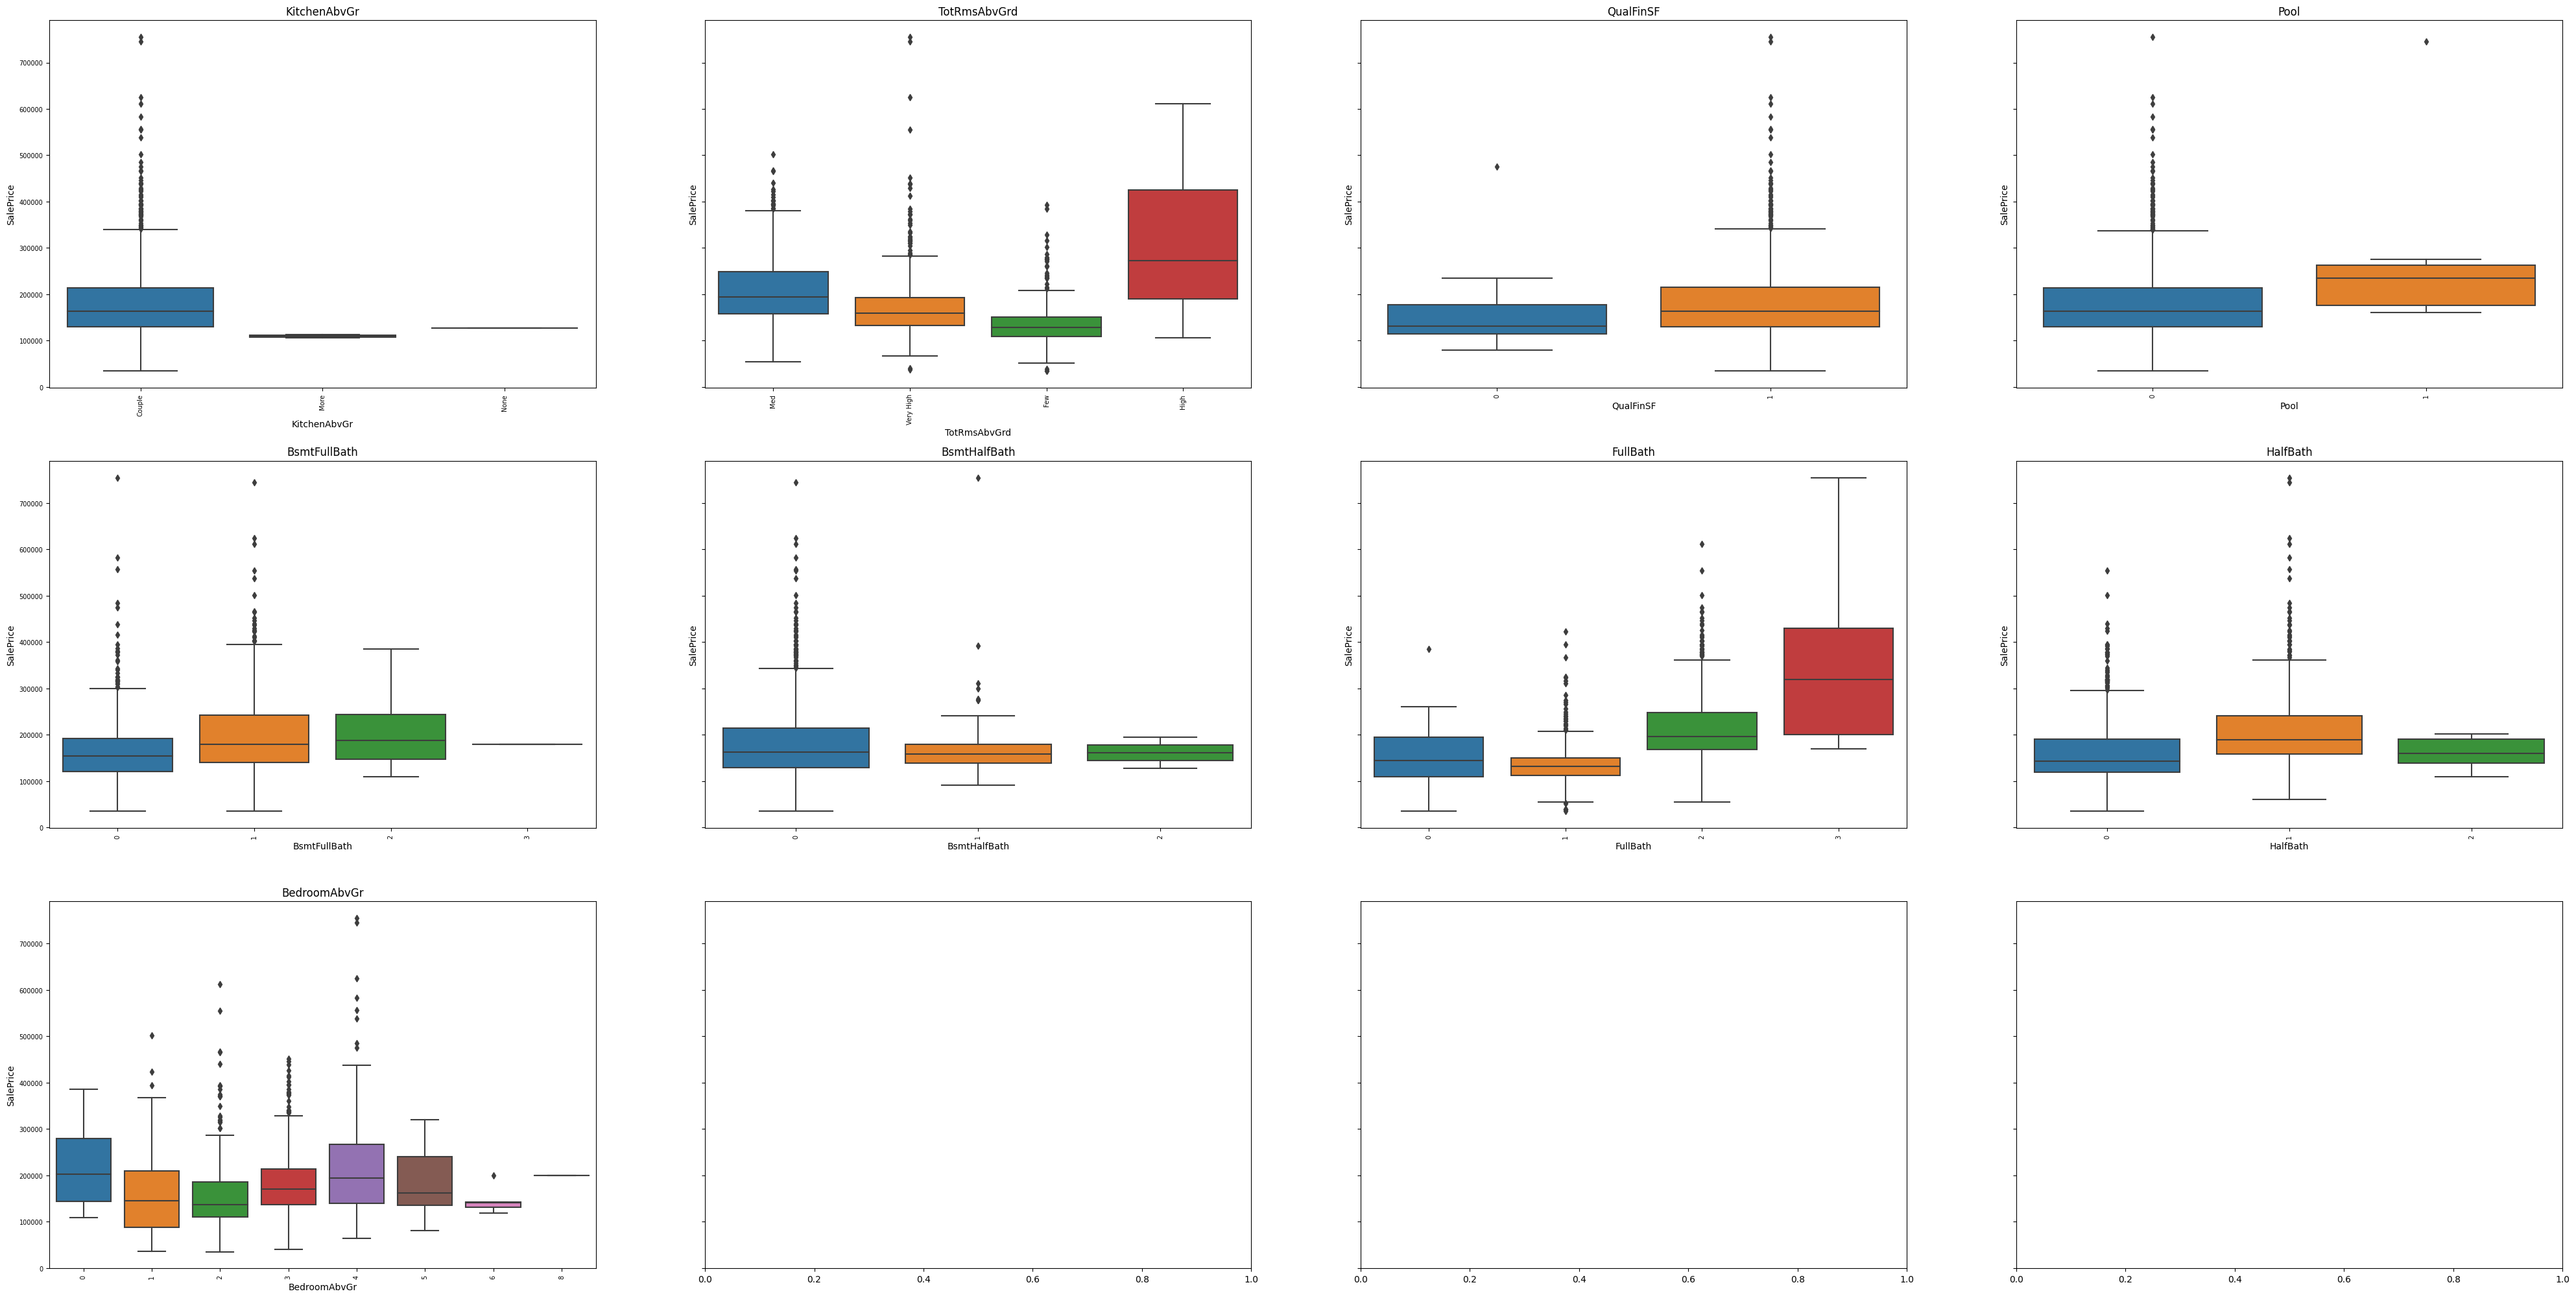

In [6]:
housing_data['KitchenAbvGr'].unique()

dict_map_KitchenAbvGr = {1:'Couple', 2:'Couple', 0:'None',3:'More'}

housing_data['KitchenAbvGr'] = housing_data['KitchenAbvGr'].map(dict_map_KitchenAbvGr)

housing_data['TotRmsAbvGrd']=housing_data['TotRmsAbvGrd'].apply(lambda x : 'Few' if x < 6 else ('Med' if ((x > 6) &(x<10))
               else ('High' if((x>10)and(x<14)) else 'Very High')))

housing_data['Pool']=housing_data['PoolArea'].apply(lambda x:0 if(x==0) else 1)
housing_data = housing_data.drop(['PoolArea'],axis=1)# Dropping PoolArea as there is a derrived column

housing_data['QualFinSF']=housing_data['LowQualFinSF'].apply(lambda x:1 if(x==0) else 0)
housing_data = housing_data.drop(['LowQualFinSF'],axis=1)# Dropping LowQualFinSF as there is a derrived column

plotSubplots(housing_data,['KitchenAbvGr','TotRmsAbvGrd','QualFinSF',
              'Pool','BsmtFullBath','BsmtHalfBath','FullBath',
              'HalfBath','BedroomAbvGr'],'SalePrice',3,4)

# Functional derrivatives

In [7]:
housing_data['YrsOnRack'] = housing_data['YrSold'] - housing_data['YearBuilt']
## Drop the two columns from which we created new one
housing_data.drop(['YrSold', 'YearBuilt'], axis=1, inplace=True)

# Get dummies

In [8]:
housing_dummies=pd.get_dummies(housing_data)
cor_matrix=housing_dummies.corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop_1 = [column for column in upper_tri.columns if any((upper_tri[column] > 0.8)|(upper_tri[column] < -0.8))]

print(to_drop_1)
housing_analysis=housing_dummies.drop(to_drop_1,axis=1)
housing_analysis.info()

['1stFlrSF', 'GarageArea', 'MSZoning_RM', 'Street_Pave', 'LotShape_Reg', 'Utilities_NoSeWa', 'LandSlope_Mod', 'Neighborhood_Somerst', 'BldgType_2fmCon', 'BldgType_Duplex', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_2Story', 'HouseStyle_SLvl', 'RoofStyle_Hip', 'RoofMatl_Tar&Grv', 'Exterior2nd_AsbShng', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'MasVnrType_None', 'ExterQual_TA', 'ExterCond_TA', 'BsmtQual_TA', 'BsmtFinType1_NA', 'BsmtFinType2_NA', 'CentralAir_Y', 'Electrical_SBrkr', 'KitchenAbvGr_More', 'KitchenQual_TA', 'FireplaceQu_NA', 'GarageType_NA', 'GarageFinish_NA', 'GarageQual_NA', 'GarageCond_Ex', 'GarageCond_NA', 'PavedDrive_Y', 'MiscFeature_Gar2', 'MiscFeature_Shed', 'SaleCondition_Partial']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 286 entries, LotFrontage to SaleCondition_Normal
dtypes: bool(257), float64(3), int64(26)
memory usag

In [9]:
sp=housing_analysis.pop('SalePrice')

housing_analysis=pd.concat([sp, housing_analysis], axis=1)
plt.figure(figsize=(200, 200))

housing_analysis.corr().sort_values(['SalePrice'], ascending=[False])['SalePrice'].index[:30]
#sns.heatmap(housing_analysis.corr(),annot=True)
#housing_analysis.info()

Index(['SalePrice', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath',
       'BsmtQual_Ex', 'YearRemodAdd', 'KitchenQual_Ex', 'Foundation_PConc',
       'MasVnrArea', 'Fireplaces', 'ExterQual_Gd', 'ExterQual_Ex',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'OverallQual_Very Good',
       'GarageFinish_Fin', 'OverallQual_Excellent', 'Neighborhood_NridgHt',
       'BsmtFinSF1', 'MSSubClass_2-STORY 1946 & NEWER',
       'OverallQual_Very Excellent', 'SaleType_New', 'FireplaceQu_Gd',
       'GarageType_Attchd', 'MasVnrType_Stone', 'Neighborhood_NoRidge',
       'WoodDeckSF', 'KitchenQual_Gd', '2ndFlrSF'],
      dtype='object')

<Figure size 20000x20000 with 0 Axes>

# Model Building and evaluation methods

In [10]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

def calculateVIF(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
    print(vif_data)

def getNFoldLinearModel(X_tr,y_tr,numberOfFeaturesToSelect=25):
    X_tr= sm.add_constant(X_tr)
    
    lr=sm.OLS(y_tr,X_tr)
    print(lr.fit().summary())

    lm=LinearRegression()
    lm.fit(X_tr, y_tr)
    
    if(numberOfFeaturesToSelect==None):
        model_cv = nfoldFeatureSelection(X_tr,y_tr,len(X_tr.columns),lm) #sm.OLS(y_tr,X_tr)
    else:
        model_cv = nfoldFeatureSelection(X_tr,y_tr,numberOfFeaturesToSelect,lm) #sm.OLS(y_tr,X_tr)

    cv_results = pd.DataFrame(model_cv.cv_results_)
    plotCVResults(cv_results)
    return lm,model_cv,X_tr

def getNFoldPolynomialModel(X_tr,y_tr,degree):    
    X_tr= sm.add_constant(X_tr)
    poly = PolynomialFeatures(degree)
    # Transforming input features to polynomial features (1, x1, x2, x3, x4, x5)    
    X_poly = poly.fit_transform(X_tr)

    lr=sm.OLS(y_tr,X_poly)
    print(lr.fit().summary())

    lm=LinearRegression()
    lm.fit(X_poly, y_tr)    

    lm=LinearRegression()
    lm.fit(X_poly, y_tr)
    
    model_cv = nfoldFeatureSelection(X_poly,y_tr,25,lm) #sm.OLS(y_tr,X_tr)

    cv_results = pd.DataFrame(model_cv.cv_results_)
    plotCVResults(cv_results)
    
    return model_cv,X_poly,poly
    
def splitTrainTest(X,y):
    return train_test_split(X, y, test_size=0.30, random_state=100)
    
def predictY(lm,X_test,y_test):
    X_test = sm.add_constant(X_test)
    y_test_pred=lm.predict(X_test)
    fig = plt.figure()
    return y_test_pred
    
def residualFitPlot(y_test,y_test_pred):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize =(5,5))
    sns.regplot(x=y_test_pred,y=y_test-y_test_pred,ax=ax)
    ax.set(ylabel='residuals',xlabel='fitted values')

def errorTerms(y_,y_pred):
    fig=plt.figure()    
    sns.distplot(y_-y_pred,bins=20)
    fig.suptitle('Error Terms',fontsize=20)
    plt.xlabel('Errors',fontsize=10)
    
def nfoldCrossValidationMetrics(reg,X_, y_):
    # create a KFold object with 5 splits 
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    
    #print(sklearn.metrics.SCORERS.keys())
    explained_variance = cross_val_score(reg, X_, y_, scoring='explained_variance', cv=folds)
    # best possible value is 1
    max_error = cross_val_score(reg, X_, y_, scoring='max_error', cv=folds)
    poisson_deviance = cross_val_score(reg, X_, y_, scoring='neg_mean_poisson_deviance', cv=folds)
    gamma_deviance = cross_val_score(reg, X_, y_, scoring='neg_mean_gamma_deviance', cv=folds)
    absolute_percentage_error = cross_val_score(reg, X_, y_, scoring='neg_mean_absolute_percentage_error', cv=folds)

    r_scores = cross_val_score(reg, X_, y_, scoring='r2', cv=folds)
    scores = cross_val_score(reg, X_, y_, scoring='neg_mean_squared_error', cv=5)
    
    return r_scores.mean(),scores.mean(),math.sqrt(scores.mean()*-1),max_error.mean(),poisson_deviance.mean(),gamma_deviance.mean(),absolute_percentage_error.mean(),explained_variance.mean()

def nfoldFeatureSelection(X_train,y_train,featuresToSelect,reg):
    # step-1: create a cross-validation scheme
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    # step-2: specify range of hyperparameters to tune
    hyper_params = [{'n_features_to_select': list(range(1, featuresToSelect))}]

    # step-3: perform grid search
    # 3.1 specify model
    rfe = RFE(reg)             

    # 3.2 call GridSearchCV()
    model=GridSearchCV(estimator = rfe, 
                            param_grid = hyper_params, 
                            scoring= 'r2', 
                            cv = folds, 
                            verbose = 0,
                            return_train_score=True)      
    model.fit(X_train, y_train)
    return model


def plotCVResults(cv_results):
    plt.figure(figsize=(16,6))

    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')

def prepareModel(df,target,targetDataTransformation):       
    if(targetDataTransformation):
        y=targetDataTransformation(df.pop(target))
    else:
        y=df.pop(target)
    X=df

    # Split train test
    X_tr, X_tst, y_trn, y_tst=splitTrainTest(X,y)
    scaler = MinMaxScaler().fit(X_tr)
    
    scaled_features=scaler.transform(X_tr.values)
    X_tr_df = pd.DataFrame(scaled_features, index=X_tr.index, columns=X_tr.columns)
    
    scaled_features=scaler.transform(X_tst.values)
    X_tst_df = pd.DataFrame(scaled_features, index=X_tst.index, columns=X_tst.columns)

    return X_tr_df, X_tst_df, y_trn, y_tst

def evaluateModel(lm,X_new, y_):
    y_pred=predictY(lm,X_new,y_)
    errorTerms(y_,y_pred)    
    return y_pred        
    
def subplot(axes,df,xaxisParameter,yaxisParameter):
    sns.regplot(x=xaxisParameter,y=yaxisParameter,data=df,ax=axes,lowess=True)
    axes.set_title(xaxisParameter)
    axes.tick_params(axis='both', which='both', labelsize=7, labelbottom=True)

def evaluatePattern(df,residual,xlimit,ylimit):
    fig, axes = plt.subplots(xlimit, ylimit, figsize=(50, 25),sharey=False)
    fig.suptitle('Vs Target Variable')
    
    x=0
    y=0
    for i in df.columns:
        subplot(axes[x,y],df,i,residual)
        if(y<ylimit-1):
            y=y+1
        else:
            x=x+1
            y=0

def buildPolyAndEvaluate(col_names,X_train,y_train,xlimit,ylimit,degree,featuresToSelect):    
    X_trn_new = X_train[col_names]
    calculateVIF(X_trn_new)
    
    lm,X_ploy,poly=getNFoldPolynomialModel(X_trn_new,y_train,degree)
    y_trn_pred=evaluateModel(lm,X_ploy,y_train)
    residualFitPlot(y_train,y_trn_pred)
    model_cv_ridge,model_cv_lasso,beta_ridge,beta_lasso=compareTrainMetric(lm,X_ploy, y_train,poly.get_feature_names_out(),featuresToSelect)
    #evaluatePattern(X_ploy[model_cv_lasso.coef_>0],y_train-y_trn_pred,xlimit,ylimit)
    return lm,model_cv_ridge,model_cv_lasso,poly,beta_ridge,beta_lasso
    
def buildAndEvaluate(col_names,X_train,y_train,xlimit,ylimit,featuresToSelect):
    X_trn_new = X_train[col_names]
    calculateVIF(X_trn_new)
    
    lm,m,X_tr=getNFoldLinearModel(X_trn_new,y_train,featuresToSelect)
    y_trn_pred=evaluateModel(lm,X_trn_new,y_train)
    residualFitPlot(y_train,y_trn_pred)
    evaluatePattern(X_trn_new,y_train-y_trn_pred,xlimit,ylimit)
    model_cv_ridge,model_cv_lasso,beta_ridge,beta_lasso=compareTrainMetric(lm,X_train, y_train,X_train.columns,featuresToSelect)
    return lm,model_cv_ridge,model_cv_lasso,beta_ridge,beta_lasso

def calculateMetric(X_,y_,y_pred):
    metric = []
    r2_ = r2_score(y_, y_pred)
    metric.append(r2_)

    rss1 = np.sum(np.square(y_ - y_pred))
    metric.append(rss1)

    mse_ = mean_squared_error(y_, y_pred)
    metric.append(mse_**0.5)

    return (metric)

# Ridge and Lasso definitions

In [11]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

def getRegularizationModel(regularization):
    # list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
    # it will not handle the overfitting
    params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

    reg = regularization()

    folds = 5
    return GridSearchCV(estimator = reg, 
                            param_grid = params, 
                            scoring= 'r2',  
                            cv = folds, 
                            return_train_score=True,
                            verbose = 0)        
    
    
def getTrainingRegularization(regularization,alpha,X_train, y_train):
    reg = regularization(alpha=alpha)

    reg.fit(X_train, y_train) 
    return reg

def getRegularizationMetric(reg,X_test, y_test):
    y_pred_test = reg.predict(X_test)
    return calculateMetric(X_test,y_test,y_pred_test)
    
def compareTrainMetric(lm,X_train_1,y_train_1,columns,compareTrainMetric):
    model_cv_ridge=getRegularizationModel(Ridge)
    model_cv_ridge.fit(X_train_1, y_train_1)

    ridgeAlpha=model_cv_ridge.best_params_['alpha']
    ridge = getTrainingRegularization(Ridge,ridgeAlpha,X_train_1, y_train_1)
    
    print(ridgeAlpha)

    model_cv_lasso=getRegularizationModel(Lasso)
    model_cv_lasso.fit(X_train_1, y_train_1)

    lassoAlpha=model_cv_lasso.best_params_['alpha']

    lasso = getTrainingRegularization(Lasso,lassoAlpha,X_train_1, y_train_1)

    print(lassoAlpha)

    lm_r21,lm_mse1,lm_rmse1,lm_max_error1,lm_poisson_deviance1,lm_gamma_deviance1,lm_abs_pt_error1,lm_explained_variance=nfoldCrossValidationMetrics(lm,X_train_1,y_train_1)

    lm_metric=[lm_r21,lm_mse1,lm_rmse1,lm_max_error1,lm_poisson_deviance1,lm_gamma_deviance1,lm_abs_pt_error1,lm_explained_variance]
    
    lm_r22,lm_mse2,lm_rmse2,lm_max_error2,lm_poisson_deviance2,lm_gamma_deviance2,lm_abs_pt_error2,lm_2explained_variance=nfoldCrossValidationMetrics(ridge,X_train_1,y_train_1)

    ridge_metric=[lm_r22,lm_mse2,lm_rmse2,lm_max_error2,lm_poisson_deviance2,lm_gamma_deviance2,lm_abs_pt_error2,lm_2explained_variance]

    lm_r23,lm_mse3,lm_rmse3,lm_max_error3,lm_poisson_deviance3,lm_gamma_deviance3,lm_abs_pt_error3,lm_3explained_variance=nfoldCrossValidationMetrics(lasso,X_train_1,y_train_1)
    
    lasso_metric=[lm_r23,lm_mse3,lm_rmse3,lm_max_error3,lm_poisson_deviance3,lm_gamma_deviance3,lm_abs_pt_error3,lm_3explained_variance]

    printFinalMetric(lm_metric,ridge_metric,lasso_metric)
    beta_ridge,beta_lasso= getCoeff(lm,ridge,lasso,X_train_1.columns)
    return ridge,lasso,beta_ridge,beta_lasso

def printFinalMetric(metric_lr,metric_ridge,metric_lasso):
    # Creating a table which contain all the metrics
    
    lr_table_3 = {'Metric': ['R2 Score','-ve MSE','RMSE', 'Poisson_deviance',
                  'Gamma_deviance','Abs pt error','Abs err score','Explained variance'],
            }

    metric_header = pd.DataFrame(lr_table_3 ,columns = ['Metric'] )
    
    rg_metric = pd.Series(metric_ridge, name = 'Ridge Regression')
    ls_metric = pd.Series(metric_lasso, name = 'Lasso Regression')

    final_metric = pd.concat([metric_header, rg_metric, ls_metric], axis = 1)
    print (final_metric)
    
def getCoeff(lm,ridge,lasso,columns):
    betas_ridge = pd.DataFrame(index=columns)
    betas_lasso = pd.DataFrame(index=columns)

    betas_ridge.rows = columns
    betas_lasso.rows = columns

    betas_ridge['Ridge'] = ridge.coef_
    betas_lasso['Lasso'] = lasso.coef_

    pd.set_option('display.max_rows', None)
    
    lasso_selected=betas_lasso[betas_lasso.Lasso>0]
    ridge_selected=betas_ridge[betas_ridge.Ridge>0]

    print(lasso_selected.sort_values(['Lasso'], ascending=[False]).head(200))
    print(ridge_selected.sort_values(['Ridge'], ascending=[False]).head(200))
    
    return ridge_selected,lasso_selected
    

# Building Model 1

                            feature       VIF
0                        GarageCars  7.198881
1                       BsmtQual_Ex  2.134998
2                      YearRemodAdd  7.062532
3                    KitchenQual_Ex  2.503358
4                        MasVnrArea  1.859480
5                        Fireplaces  3.333173
6                      ExterQual_Gd  3.558050
7                  BsmtFinType1_GLQ  2.515331
8                      HeatingQC_Ex  3.473325
9             OverallQual_Very Good  1.837455
10                 GarageFinish_Fin  1.866436
11            OverallQual_Excellent  1.975552
12             Neighborhood_NridgHt  1.741492
13                       BsmtFinSF1  3.062523
14  MSSubClass_2-STORY 1946 & NEWER  2.788854
15       OverallQual_Very Excellent  1.622969
16                     SaleType_New  1.502624
17                   FireplaceQu_Gd  2.211933
18                GarageType_Attchd  3.431398
19                 MasVnrType_Stone  1.543929
20             Neighborhood_NoRidg

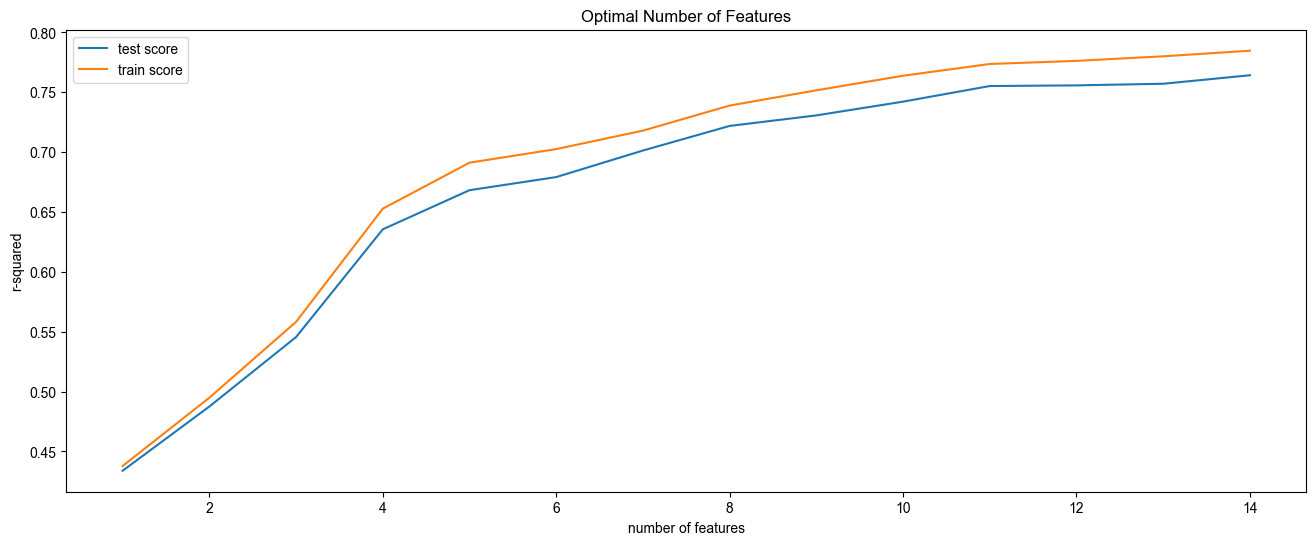

<Figure size 640x480 with 0 Axes>

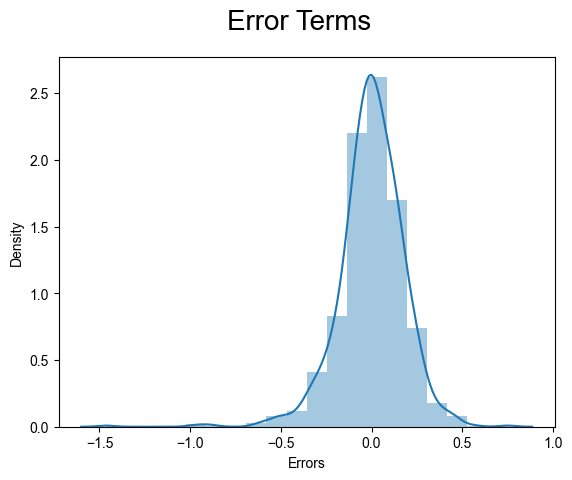

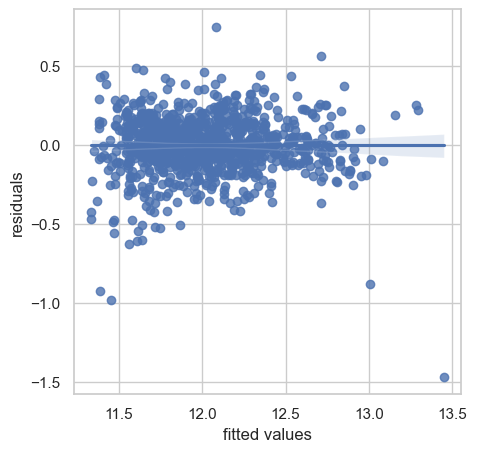

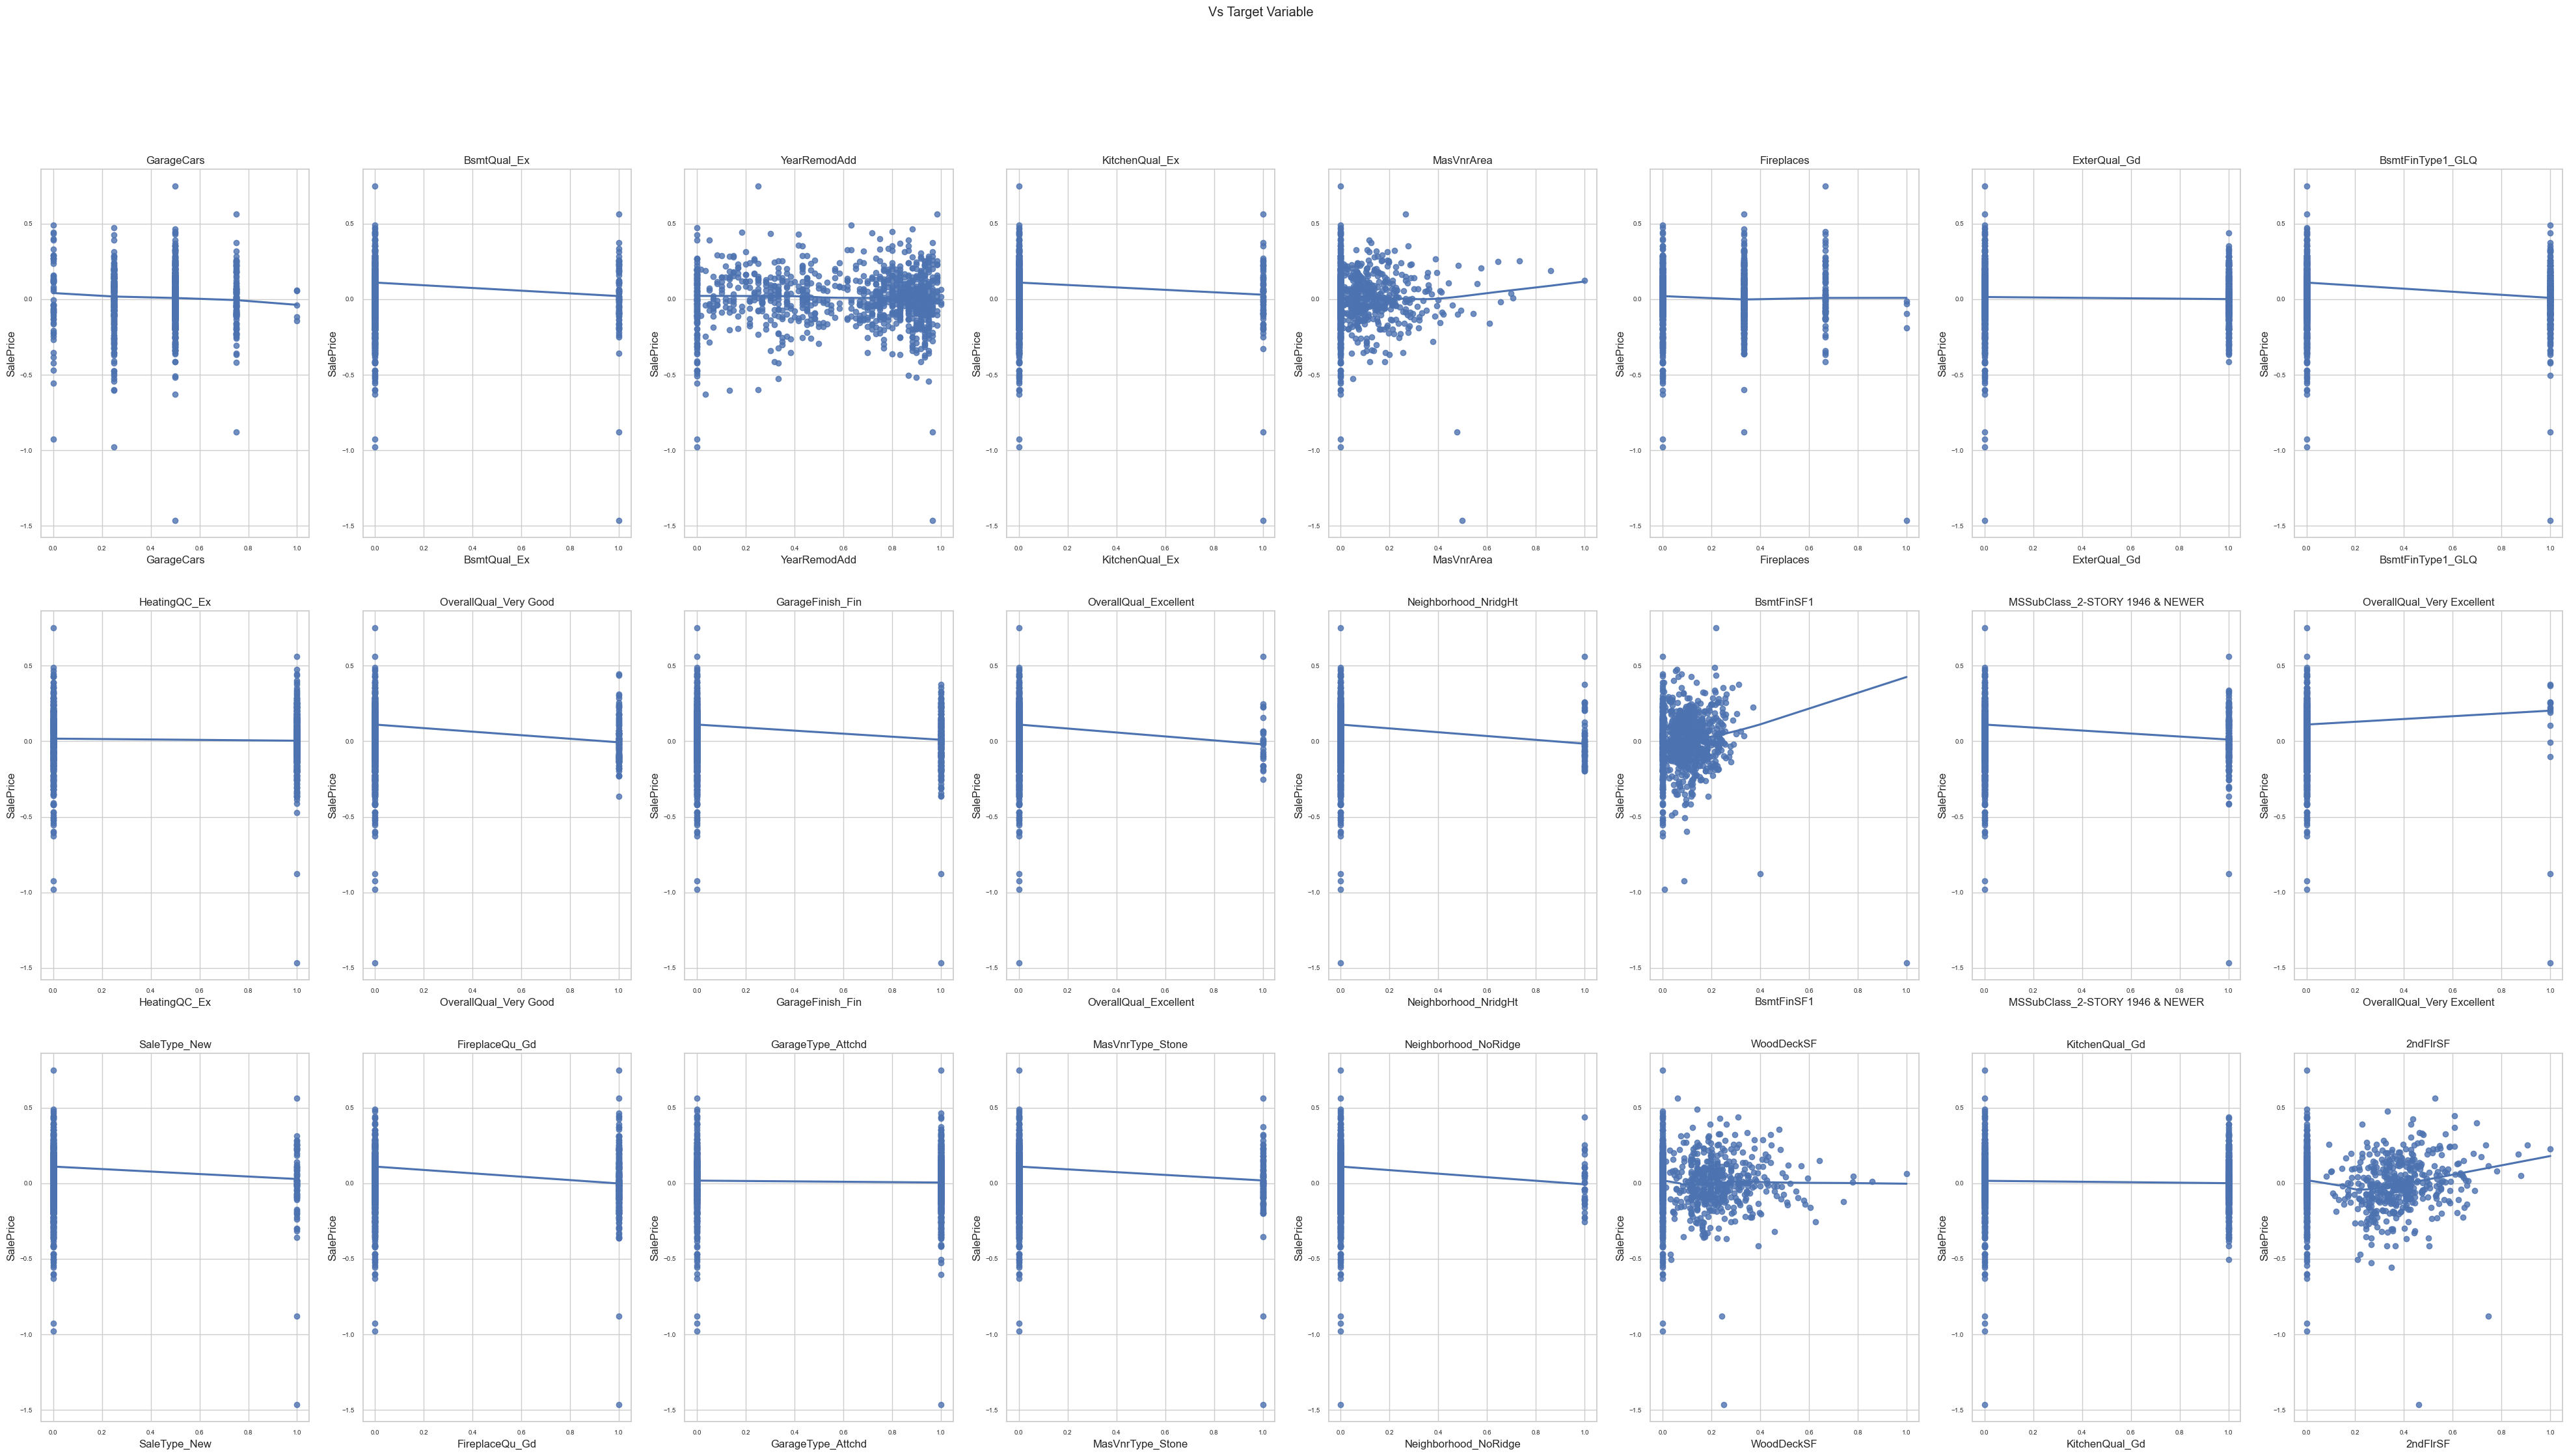

In [12]:
#BuildingModel1
housing_analysis1 = housing_analysis[housing_analysis.columns]
#Starting with the columns that have the highest corr with SalePrice and removing based on VIF and significance
col_names_1=[ 'GarageCars', 'BsmtQual_Ex', 'YearRemodAdd', 
             'KitchenQual_Ex','MasVnrArea', 'Fireplaces', 
             'ExterQual_Gd','BsmtFinType1_GLQ', 'HeatingQC_Ex', 
             'OverallQual_Very Good','GarageFinish_Fin', 'OverallQual_Excellent', 
             'Neighborhood_NridgHt','BsmtFinSF1', 'MSSubClass_2-STORY 1946 & NEWER',
             'OverallQual_Very Excellent', 'SaleType_New', 'FireplaceQu_Gd',
             'GarageType_Attchd', 'MasVnrType_Stone', 'Neighborhood_NoRidge',
            'WoodDeckSF', 'KitchenQual_Gd', '2ndFlrSF']

X_train_1,X_test_1,y_train_1,y_test_1=prepareModel(housing_analysis1,'SalePrice',np.log)
lm1,metric_Reg_ridge1,metric_Reg_lasso1,beta_ridge1,beta_lasso1 = buildAndEvaluate(col_names_1,X_train_1,y_train_1,3,8,15)


In [13]:
(beta_lasso1.sort_values(['Lasso'], ascending=[False])['Lasso']).index

Index(['GrLivArea', 'GarageCars', 'OverallQual_Excellent', 'FullBath',
       'OverallQual_Very Good', 'Neighborhood_Crawfor', 'MSZoning_FV',
       'BsmtQual_Ex', 'YearRemodAdd', 'KitchenQual_Ex', 'BsmtFullBath',
       'BsmtExposure_Gd', 'Neighborhood_NoRidge', 'Fireplaces',
       'Functional_Typ', 'Neighborhood_ClearCr', 'Neighborhood_NridgHt',
       'WoodDeckSF', 'Exterior1st_BrkFace', 'LotConfig_CulDSac',
       'OverallQual_Good', 'MSZoning_RL',
       'MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 'Neighborhood_StoneBr',
       'Condition1_Norm', 'FireplaceQu_Gd', 'BldgType_1Fam',
       'BsmtFinType1_GLQ', 'GarageCond_TA', 'ExterQual_Ex', 'HalfBath',
       'GarageType_Attchd', 'ExterQual_Gd', 'HeatingQC_Ex', 'FireplaceQu_TA',
       'BsmtQual_Gd', 'BsmtFinType1_ALQ', 'LandContour_Low', 'FireplaceQu_Ex',
       'TotRmsAbvGrd_Med', 'KitchenQual_Gd', 'OverallCond_Good',
       'Neighborhood_BrkSide', 'TotRmsAbvGrd_Very High', 'ScreenPorch',
       'Exterior1st_VinylSd', 'BsmtUnf

                                       feature        VIF
0                                    GrLivArea  18.478842
1                                   GarageCars  15.335166
2                        OverallQual_Excellent   1.842609
3                                     FullBath  23.905450
4                        OverallQual_Very Good   2.475255
5                         Neighborhood_Crawfor   1.184484
6                                  MSZoning_FV   1.736899
7                                  BsmtQual_Ex   3.119256
8                                 YearRemodAdd   9.280867
9                               KitchenQual_Ex   2.662959
10                                BsmtFullBath   2.949502
11                             BsmtExposure_Gd   1.525003
12                        Neighborhood_NoRidge   1.497770
13                                  Fireplaces   7.847004
14                              Functional_Typ  13.690602
15                        Neighborhood_ClearCr   1.346342
16            

4.0
0.001
               Metric  Ridge Regression  Lasso Regression
0            R2 Score          0.877926          0.877311
1             -ve MSE         -0.019702         -0.019327
2                RMSE          0.140364          0.139023
3    Poisson_deviance         -0.820643         -0.881213
4      Gamma_deviance         -0.001595         -0.001606
5        Abs pt error         -0.000133         -0.000133
6       Abs err score         -0.007898         -0.007632
7  Explained variance          0.878754          0.878071
                                               Lasso
GrLivArea                                   1.107665
GarageCars                                  0.221394
OverallQual_Excellent                       0.167731
FullBath                                    0.128673
OverallQual_Very Good                       0.125720
Neighborhood_Crawfor                        0.110239
MSZoning_FV                                 0.100011
BsmtQual_Ex                                 

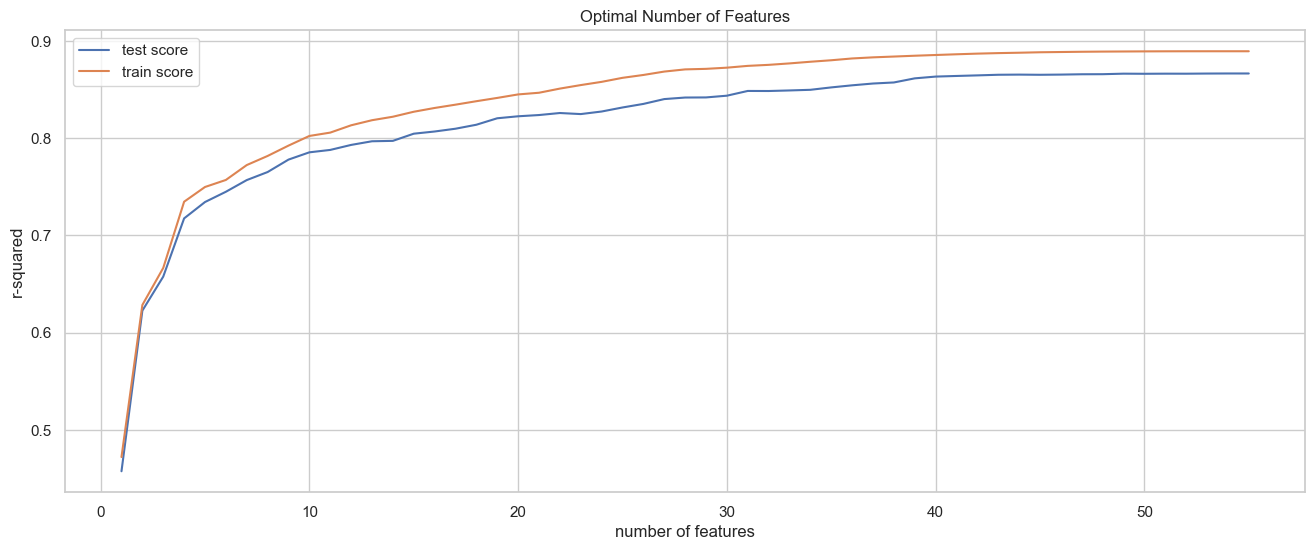

<Figure size 640x480 with 0 Axes>

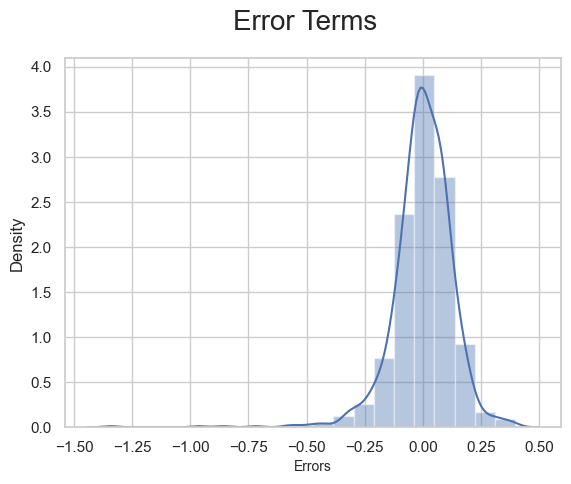

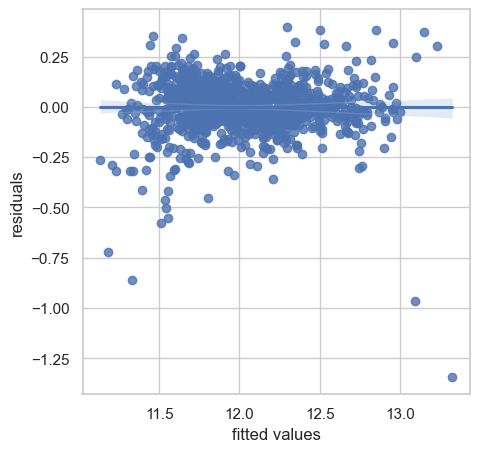

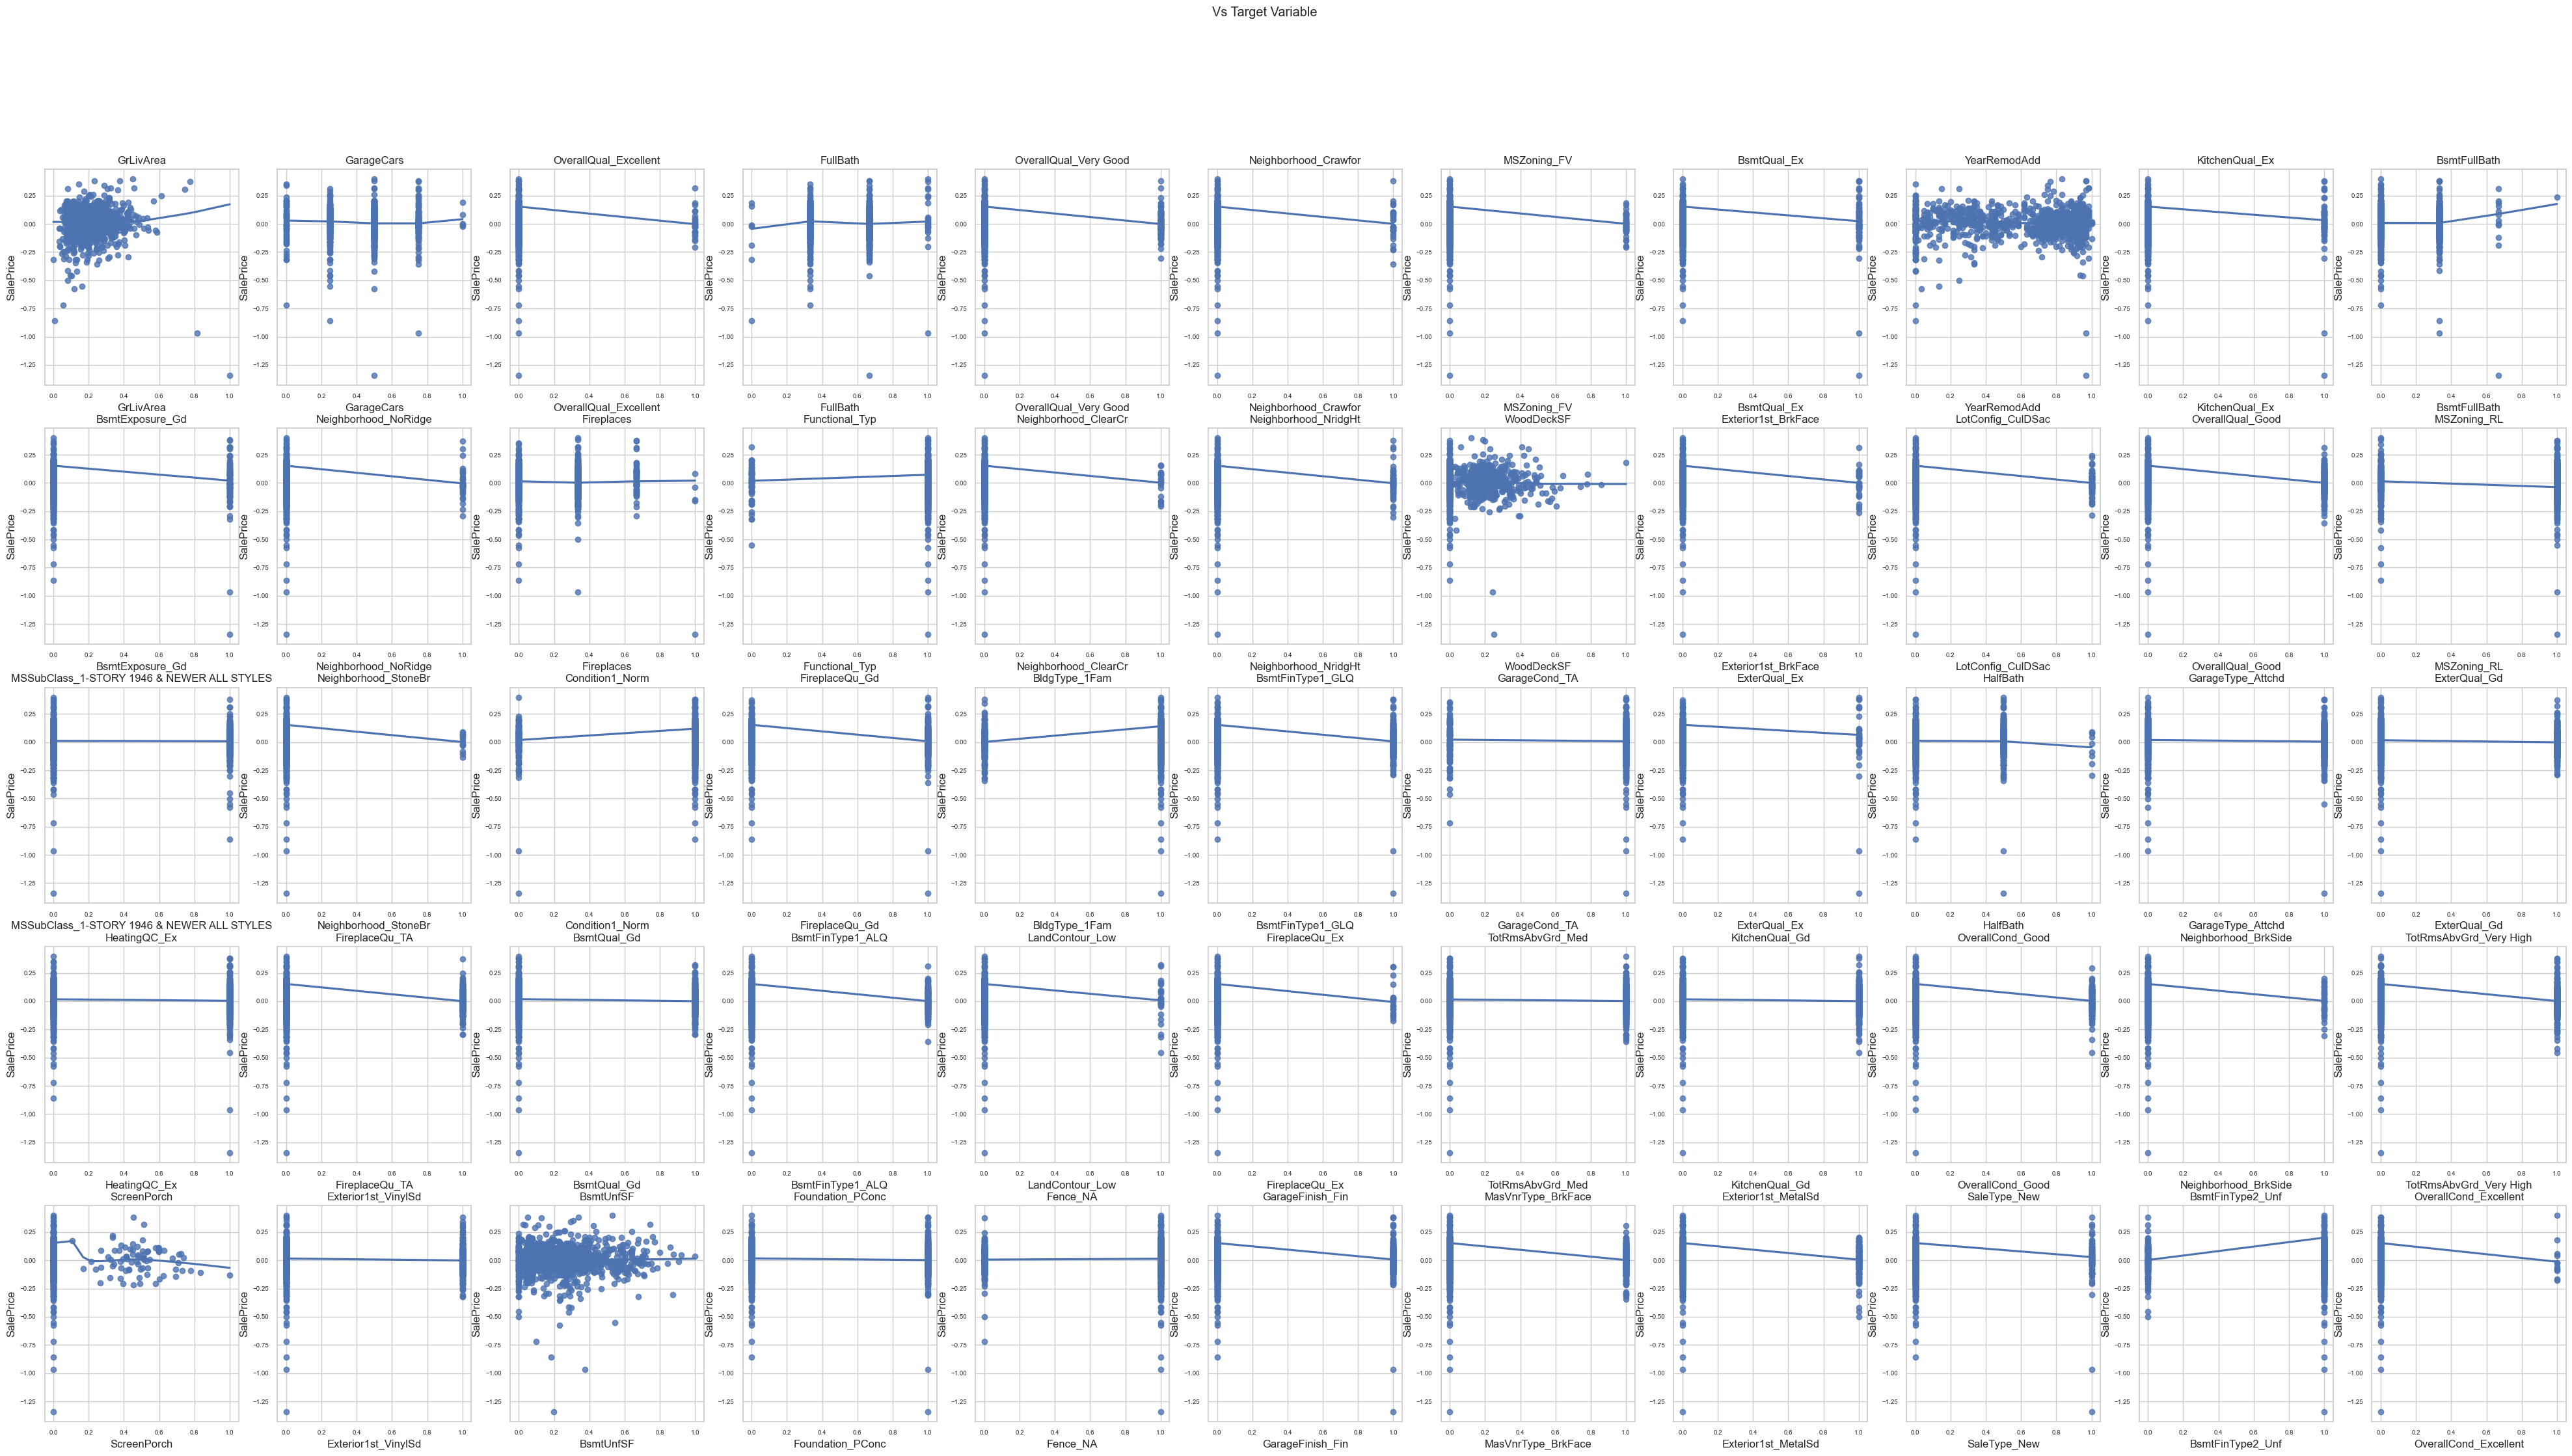

In [14]:
#BuildingModel1
housing_analysis12 = housing_analysis[housing_analysis.columns]
#Starting with the columns that have the highest corr with SalePrice and removing based on VIF and significance
col_names_12=['GrLivArea', 'GarageCars', 'OverallQual_Excellent', 'FullBath',
       'OverallQual_Very Good', 'Neighborhood_Crawfor', 'MSZoning_FV',
       'BsmtQual_Ex', 'YearRemodAdd', 'KitchenQual_Ex', 'BsmtFullBath',
       'BsmtExposure_Gd', 'Neighborhood_NoRidge', 'Fireplaces',
       'Functional_Typ', 'Neighborhood_ClearCr', 'Neighborhood_NridgHt',
       'WoodDeckSF', 'Exterior1st_BrkFace', 'LotConfig_CulDSac',
       'OverallQual_Good', 'MSZoning_RL',
       'MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 'Neighborhood_StoneBr',
       'Condition1_Norm', 'FireplaceQu_Gd', 'BldgType_1Fam',
       'BsmtFinType1_GLQ', 'GarageCond_TA', 'ExterQual_Ex', 'HalfBath',
       'GarageType_Attchd', 'ExterQual_Gd', 'HeatingQC_Ex', 'FireplaceQu_TA',
       'BsmtQual_Gd', 'BsmtFinType1_ALQ', 'LandContour_Low', 'FireplaceQu_Ex',
       'TotRmsAbvGrd_Med', 'KitchenQual_Gd', 'OverallCond_Good',
       'Neighborhood_BrkSide', 'TotRmsAbvGrd_Very High', 'ScreenPorch',
       'Exterior1st_VinylSd', 'BsmtUnfSF', 'Foundation_PConc', 'Fence_NA',
       'GarageFinish_Fin', 'MasVnrType_BrkFace', 'Exterior1st_MetalSd',
       'SaleType_New', 'BsmtFinType2_Unf', 'OverallCond_Excellent']

X_train_12,X_test_12,y_train_12,y_test_12=prepareModel(housing_analysis12,'SalePrice',np.log)
lm12,metric_Reg_ridge12,metric_Reg_lasso12,beta_ridge12,beta_lasso12 = buildAndEvaluate(col_names_12,X_train_1,y_train_1,5,11,None)


# Building Model 2

                      feature       VIF
0            OverallQual_Good  1.964229
1       OverallQual_Very Good  1.876309
2       OverallQual_Excellent  1.237408
3  OverallQual_Very Excellent  1.166581
4          GrLivArea_cat_High  1.761230
5     GrLivArea_cat_Above Avg  1.496314
6                  GarageCars  4.822854
7              KitchenQual_Gd  2.420688
8            GarageFinish_Unf  1.755380
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     318.1
Date:                Sat, 13 May 2023   Prob (F-statistic):          7.82e-288
Time:                        20:34:34   Log-Likelihood:                 181.20
No. Observations:                1022   AIC:                            -342.4
Df Residuals:                    1012   BIC:   

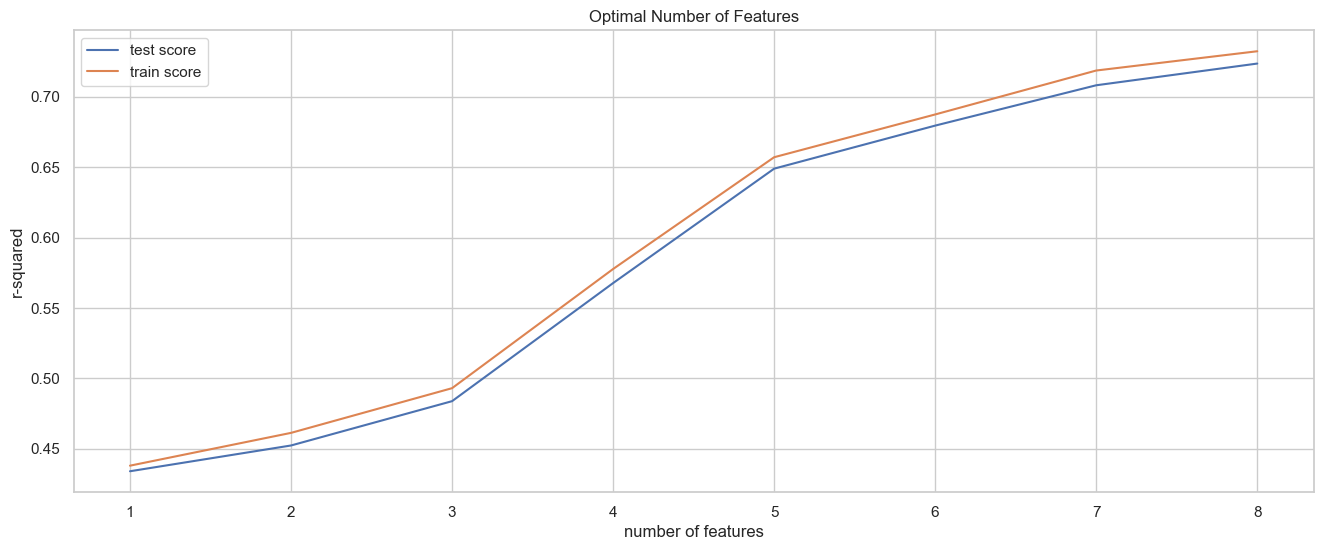

<Figure size 640x480 with 0 Axes>

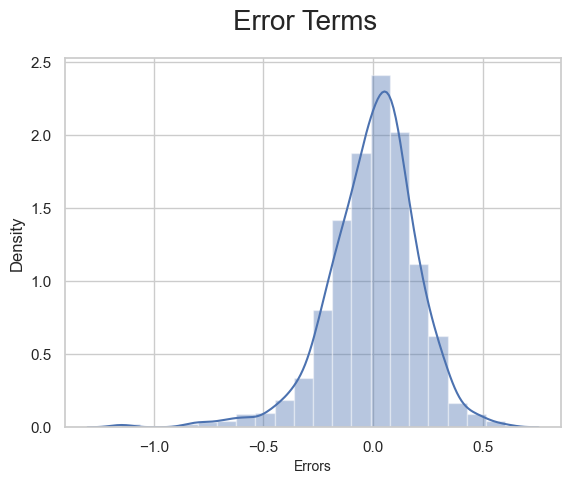

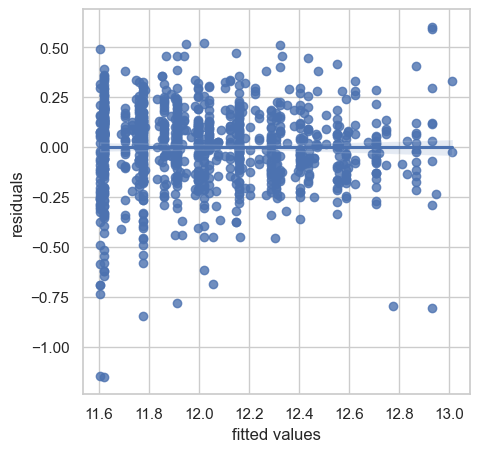

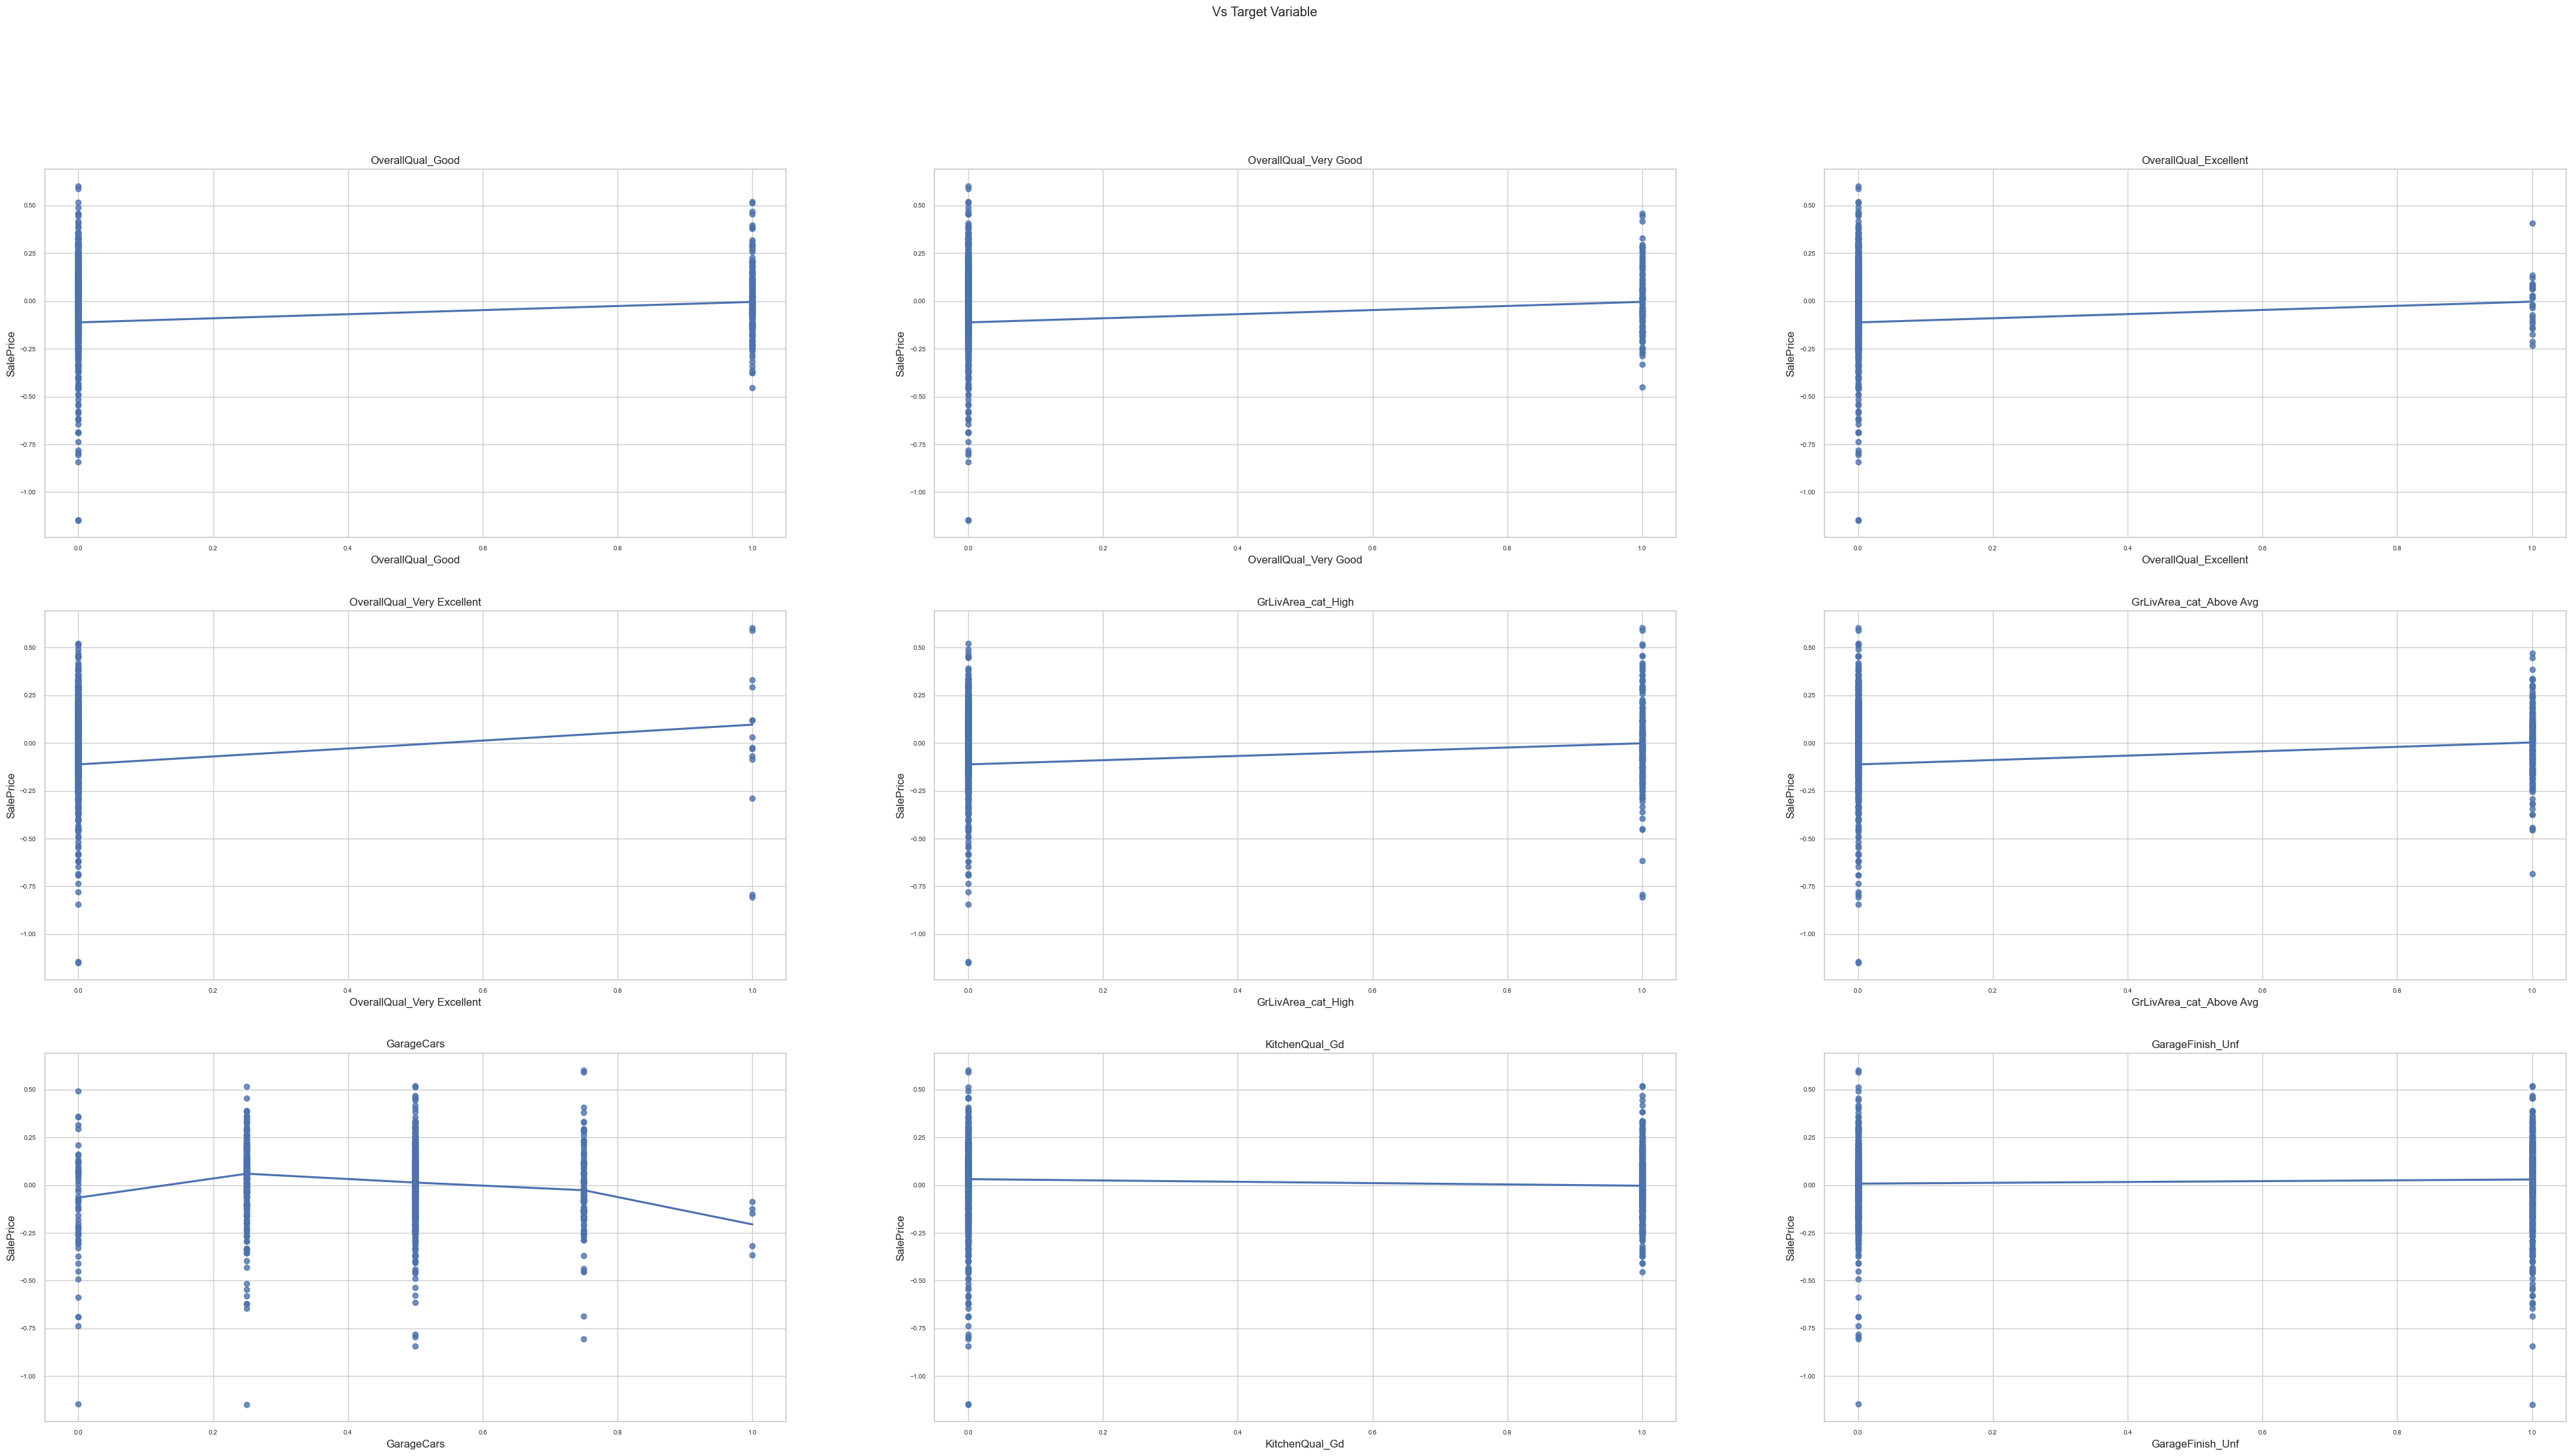

In [15]:
#BuildingModel2
housing_analysis2 = housing_analysis[housing_analysis.columns]

housing_analysis2['GrLivArea_cat']= pd.qcut(housing_analysis2.GrLivArea,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
housing_analysis2 = housing_analysis2.drop(['GrLivArea'],axis=1)

housing_analysis2=pd.get_dummies(housing_analysis2, drop_first=True)

col_names_2=['OverallQual_Good','OverallQual_Very Good','OverallQual_Excellent',
             'OverallQual_Very Excellent','GrLivArea_cat_High',
             'GrLivArea_cat_Above Avg','GarageCars','KitchenQual_Gd','GarageFinish_Unf']

X_train_2,X_test_2,y_train_2,y_test_2=prepareModel(housing_analysis2,'SalePrice',np.log)
lm21,metric_Reg_ridge21,metric_Reg_lasso21,beta_ridge21,beta_lasso21 = buildAndEvaluate(col_names_2,X_train_2,y_train_2,3,3,9)


In [16]:
(beta_lasso21.sort_values(['Lasso'], ascending=[False])[:50]).index

Index(['GrLivArea_cat_High', 'GarageCars', 'GrLivArea_cat_Above Avg',
       'OverallQual_Excellent', 'FullBath', 'GrLivArea_cat_Avg',
       'OverallQual_Very Excellent', 'OverallQual_Very Good',
       'Neighborhood_NoRidge', 'Neighborhood_Crawfor', 'BsmtFullBath',
       'YearRemodAdd', 'BsmtQual_Ex', 'TotalBsmtSF', 'MSZoning_FV',
       'KitchenQual_Ex', 'BsmtExposure_Gd', 'Fireplaces', 'Functional_Typ',
       'WoodDeckSF', 'BldgType_1Fam', 'Exterior1st_BrkFace',
       'GrLivArea_cat_Below Avg', 'MSZoning_RL', 'Neighborhood_ClearCr',
       'Condition1_Norm', 'LotConfig_CulDSac', 'OverallQual_Good',
       'FireplaceQu_Gd', 'Neighborhood_NridgHt', 'BsmtUnfSF', 'GarageCond_TA',
       'BsmtFinType1_GLQ', 'OverallCond_Excellent', 'GarageType_Attchd',
       'TotRmsAbvGrd_Very High', 'HalfBath', '2ndFlrSF', 'ExterQual_Gd',
       'Neighborhood_StoneBr', 'HeatingQC_Ex', 'SaleType_New',
       'MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 'BsmtQual_Gd',
       'Neighborhood_BrkSide', 

In [ ]:
#BuildingModel2
housing_analysis2 = housing_analysis[housing_analysis.columns]

housing_analysis2['GrLivArea_cat']= pd.qcut(housing_analysis2.GrLivArea,  5, labels=["Low","Below Avg","Avg","Above Avg","High"])
housing_analysis2=pd.get_dummies(housing_analysis2, drop_first=True)

col_names_22=['GrLivArea_cat_High', 'GarageCars', 'GrLivArea_cat_Above Avg',
       'OverallQual_Excellent', 'FullBath', 'GrLivArea_cat_Avg',
       'OverallQual_Very Excellent', 'OverallQual_Very Good',
       'Neighborhood_NoRidge', 'Neighborhood_Crawfor', 'BsmtFullBath',
       'YearRemodAdd', 'BsmtQual_Ex', 'TotalBsmtSF', 'MSZoning_FV',
       'KitchenQual_Ex', 'BsmtExposure_Gd', 'Fireplaces', 'Functional_Typ',
       'WoodDeckSF', 'BldgType_1Fam', 'Exterior1st_BrkFace',
       'GrLivArea_cat_Below Avg', 'MSZoning_RL', 'Neighborhood_ClearCr',
       'Condition1_Norm', 'LotConfig_CulDSac', 'OverallQual_Good',
       'FireplaceQu_Gd', 'Neighborhood_NridgHt', 'BsmtUnfSF', 'GarageCond_TA',
       'BsmtFinType1_GLQ', 'OverallCond_Excellent', 'GarageType_Attchd',
       'TotRmsAbvGrd_Very High', 'HalfBath', '2ndFlrSF', 'ExterQual_Gd',
       'Neighborhood_StoneBr', 'HeatingQC_Ex', 'SaleType_New',
       'MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 'BsmtQual_Gd',
       'Neighborhood_BrkSide', 'OverallCond_Good', 'HouseStyle_1Story',
       'Heating_GasW', 'Foundation_PConc', 'FireplaceQu_Ex']
X_train_22,X_test_22,y_train_22,y_test_22=prepareModel(housing_analysis2,'SalePrice',np.log)
lm22,metric_Reg_ridge22,metric_Reg_lasso22,beta_ridge22,beta_lasso22 = buildAndEvaluate(col_names_22,X_train_22,y_train_22,5,10,25)


# Testing on unseen data

Selecting the model 1 because it has better RMSE on Lasso

In [ ]:
X_test_1= sm.add_constant(X_test_1)

cols=beta_lasso1.sort_values(['Lasso'], ascending=[False])['Lasso'].index
print(getRegularizationMetric(metric_Reg_lasso1,X_test_1, y_test_1))


Among Lasso and Ridge you can choose based on the requirement. If accuracy is more important you can go for Ridge, but the model will be complex. If you want lesser number of predictors then go for Lasso

In [ ]:
X_test_1= sm.add_constant(X_test_1)

cols=beta_ridge1.sort_values(['Ridge'], ascending=[False])['Ridge'].index
print(getRegularizationMetric(metric_Reg_ridge1,X_test_1, y_test_1))


# Removing top 5 predictors from incoming data

In [ ]:
housing_analysis_without_top_5 = housing_analysis[housing_analysis.columns]

housing_analysis_without_top_5 = housing_analysis_without_top_5.drop(['GrLivArea', 'GarageCars', 'OverallQual_Excellent', 'FullBath','OverallQual_Very Good'],axis=1)
col_names_without_top_5=['Neighborhood_Crawfor', 'MSZoning_FV',
       'BsmtQual_Ex', 'YearRemodAdd', 'KitchenQual_Ex', 'BsmtFullBath',
       'BsmtExposure_Gd', 'Neighborhood_NoRidge', 'Fireplaces',
       'Functional_Typ', 'Neighborhood_ClearCr', 'Neighborhood_NridgHt',
       'WoodDeckSF', 'Exterior1st_BrkFace', 'LotConfig_CulDSac',
       'OverallQual_Good', 'MSZoning_RL',
       'MSSubClass_1-STORY 1946 & NEWER ALL STYLES', 'Neighborhood_StoneBr']

X_train_12,X_test_12,y_train_12,y_test_12=prepareModel(housing_analysis_without_top_5,'SalePrice',np.log)
lm112,metric_Reg_ridge12,metric_Reg_lasso12,beta_ridge12,beta_lasso12 = buildAndEvaluate(col_names_without_top_5,X_train_12,y_train_12,5,10,15)


# The new top 5 predictors of Lasso are

1. Neighborhood_Crawfor  1.099682
2. MSZoning_FV  1.376475
3. BsmtQual_Ex  1.776683
4. YearRemodAdd  4.977824
5. KitchenQual_Ex  1.663053